### Initial run

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [19]:
from benchmarking.analysis.analyze_results import *

In [35]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/motivation/last_run_3")

In [36]:
s3_folder_filter="*s3*"
scratch_folder_filter="*scratch*"

Load the data

In [37]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 234.37it/s]


Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

Extract the GPU Utilization data

In [38]:
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter, ms=True, skip=8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [01:07<00:00,  1.64it/s]


In [39]:
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter, ms=True, skip=8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:05<00:00, 19.91it/s]


In [40]:
np.unique(df_dataloader_scratch["item_y"])
# df_dataloader_scratch

array(['advance', 'batch', 'next_data', 'optimizer_step',
       'postrun_training_batch', 'prep_training_batch', 'prerun',
       'reset_timeline', 'run_training_batch', 'training_batch_to_device',
       'update_loss'], dtype=object)

### Plot function timelines for remote storage (AWS S3)

In [41]:
def show_timelines_with_gpu2(df, gpu_util, lanes, colors, run, flat=False, show_gpu=False, zoom=False, 
                            zoom_epochs=1, gpu_index="2", skip_plot=False, ms=False, fig_params=None, skip_title=False):
    fig, ax = None, None
    if not skip_plot:
        fig, ax = plt.subplots(figsize=(30, 25))
    if fig_params is None:
        plt.rcParams.update({"font.size": 18})
    else:
        plt.rcParams.update(fig_params)
    start = min(df["start_time_x"])
    end = max(df["end_time_y"])
    ts = "timestamp"
    if ms:
        ts = f"timestamp_{gpu_index}"
    print(ts, ms)
    gpu_start = min(gpu_util[ts])

    total_runtime = end - start
    number_of_epochs = 20
    ctr = 0
    if zoom:
        df = df[df["start_time_x"] < start + ((total_runtime / number_of_epochs) * zoom_epochs)]
        gpu_util = gpu_util[gpu_util[ts] < gpu_start + ((total_runtime / number_of_epochs) * zoom_epochs)]

    lane = 0
    filename = run.split("_")
    if not skip_plot:
        for _, row in df.sort_values(["start_time_x"], ascending=True).iterrows():
            duration = row["end_time_y"] - row["start_time_x"]
            x1 = row["start_time_x"] - start
            # if duration < 0.15:
            #     duration = 0.2
            x2 = x1 + duration
            if not flat:
                lane += 10
            else:
                lane = lanes[row["item_x"]]
            if row["item_x"] != "reset_timeline" and row["item_x"] != "update_loss":
                ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=3)
                ctr += 1
            if row["item_x"] == "update_loss":
                ax.plot([x1, x2], [lane, lane], color="black", label=row["item_x"], linewidth=3)
        print(f"Printed: {ctr}")

        ax.set_xlabel("Experiment duration (S)", loc="right")
        ax.set_ylabel("Operation activity lane", loc="center")

        ax.legend()
        ax.grid(linestyle="--", which="both")

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))

        # Put a legend below current axis
        ax.legend(
            by_label.values(),
            by_label.keys(),
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=5,
        )

    gpu_util_mean_no_zeros = 0
    gpu_util_zeros = 0
    mem_util_mean_no_zeros = 0
    mem_util_mean = 0
    
    gpu_util_zeros = (len(gpu_util[gpu_util[f"gpu_util_{gpu_index}"] == 0][f"gpu_util_{gpu_index}"]) / len(gpu_util[f"gpu_util_{gpu_index}"])) * 100
    gpu_util_mean_no_zeros = np.mean(gpu_util[gpu_util[f"gpu_util_{gpu_index}"] > 0][f"gpu_util_{gpu_index}"])
    mem_util_mean = np.mean(gpu_util[f"mem_util_{gpu_index}"])
    mem_util_mean_no_zeros = np.mean(gpu_util[gpu_util[f"mem_util_{gpu_index}"] > 0][f"mem_util_{gpu_index}"])

    if show_gpu:
        ax2 = ax.twinx()
        ax2.set_ylabel("GPU/Memory utilization (green, maroon) [%]")

        r"{\fontsize{50pt}{3em}\selectfont{}a}{\fontsize{20pt}{3em}\selectfont{}N"
        ax2.set_ylim([-3, 103])
        gpu_events = []
        for i in gpu_util[ts]:
            gpu_events.append(i - start)
        ax2.plot(gpu_events, gpu_util[f"gpu_util_{gpu_index}"], color="cyan", linestyle="--", linewidth=2)
        ax2.plot(gpu_events, gpu_util[f"mem_util_{gpu_index}"], color="maroon", linestyle="--", linewidth=2)
        ax2.plot(
            gpu_events, [gpu_util_mean_no_zeros] * len(gpu_events), label="GPU Util Mean", linewidth=2, color="cyan"
        )
        ax2.plot(
            gpu_events, [mem_util_mean_no_zeros] * len(gpu_events), label="Mem Util Mean", linewidth=2, color="maroon"
        )
        print(gpu_util_mean_no_zeros, mem_util_mean_no_zeros)
        ax2.legend()

    gpu_util = ""
    if show_gpu:
        gpu_util = f"GPU unused: {round(gpu_util_zeros, 2)} %, mean GPU usage: {round(gpu_util_mean_no_zeros, 2)} %",
 
    if not skip_plot:
        ax.set_title(
            f"Total runtime per operation \n Implementation: {filename[9]},"
            # f" use cache: {filename[8]}, "
            f" batch size: {filename[5]}, "
            f" library: {filename[3]}, "
            f"{gpu_util}",
            loc="center",
        )

    plt.show()
 
    return {
        "runtime": end - start,
        "gpu_util_zero": gpu_util_zeros,
        "gpu_util_mean_no_zeros": gpu_util_mean_no_zeros,
        "mem_util_mean": mem_util_mean,
        "mem_util_mean_no_zeros": mem_util_mean_no_zeros,
        "implementation": filename[9],
        "cache": filename[8],
        "library": filename[3],
        "fig": fig,
    }


### Plot function timelines for local storage

['advance', 'next_data', 'optimizer_step', 'postrun_training_batch', 'prep_training_batch', 'prerun', 'reset_timeline', 'update_loss', 'batch', 'training_batch_to_device', 'run_training_batch']
timestamp_2 True
Printed: 139
65.41916167664671 37.416666666666664


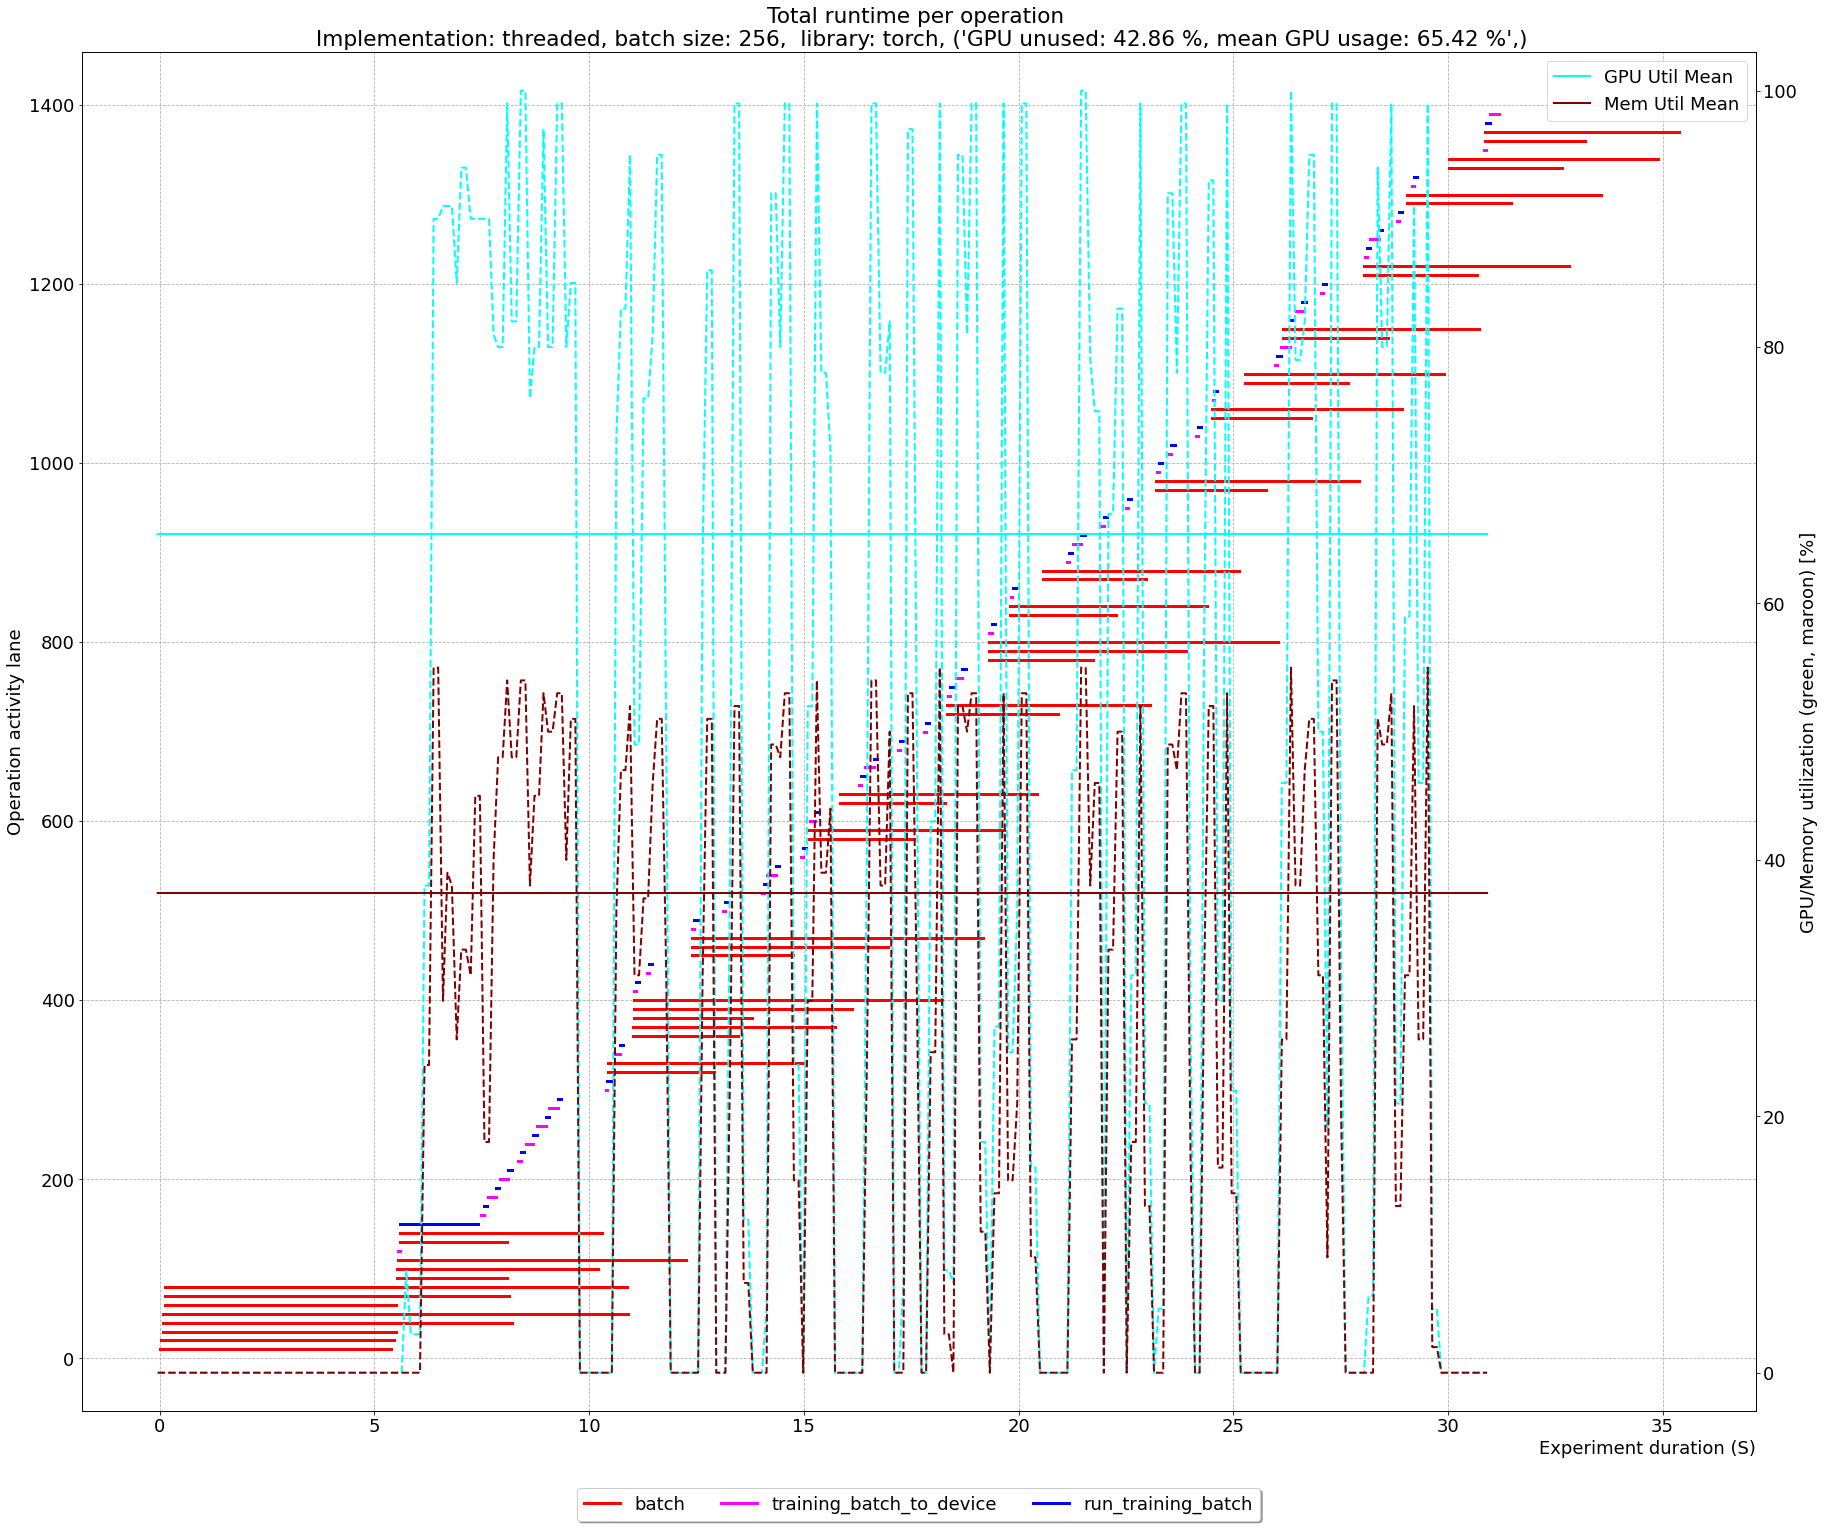

timestamp_2 True
Printed: 347
66.99441340782123 21.251655629139073


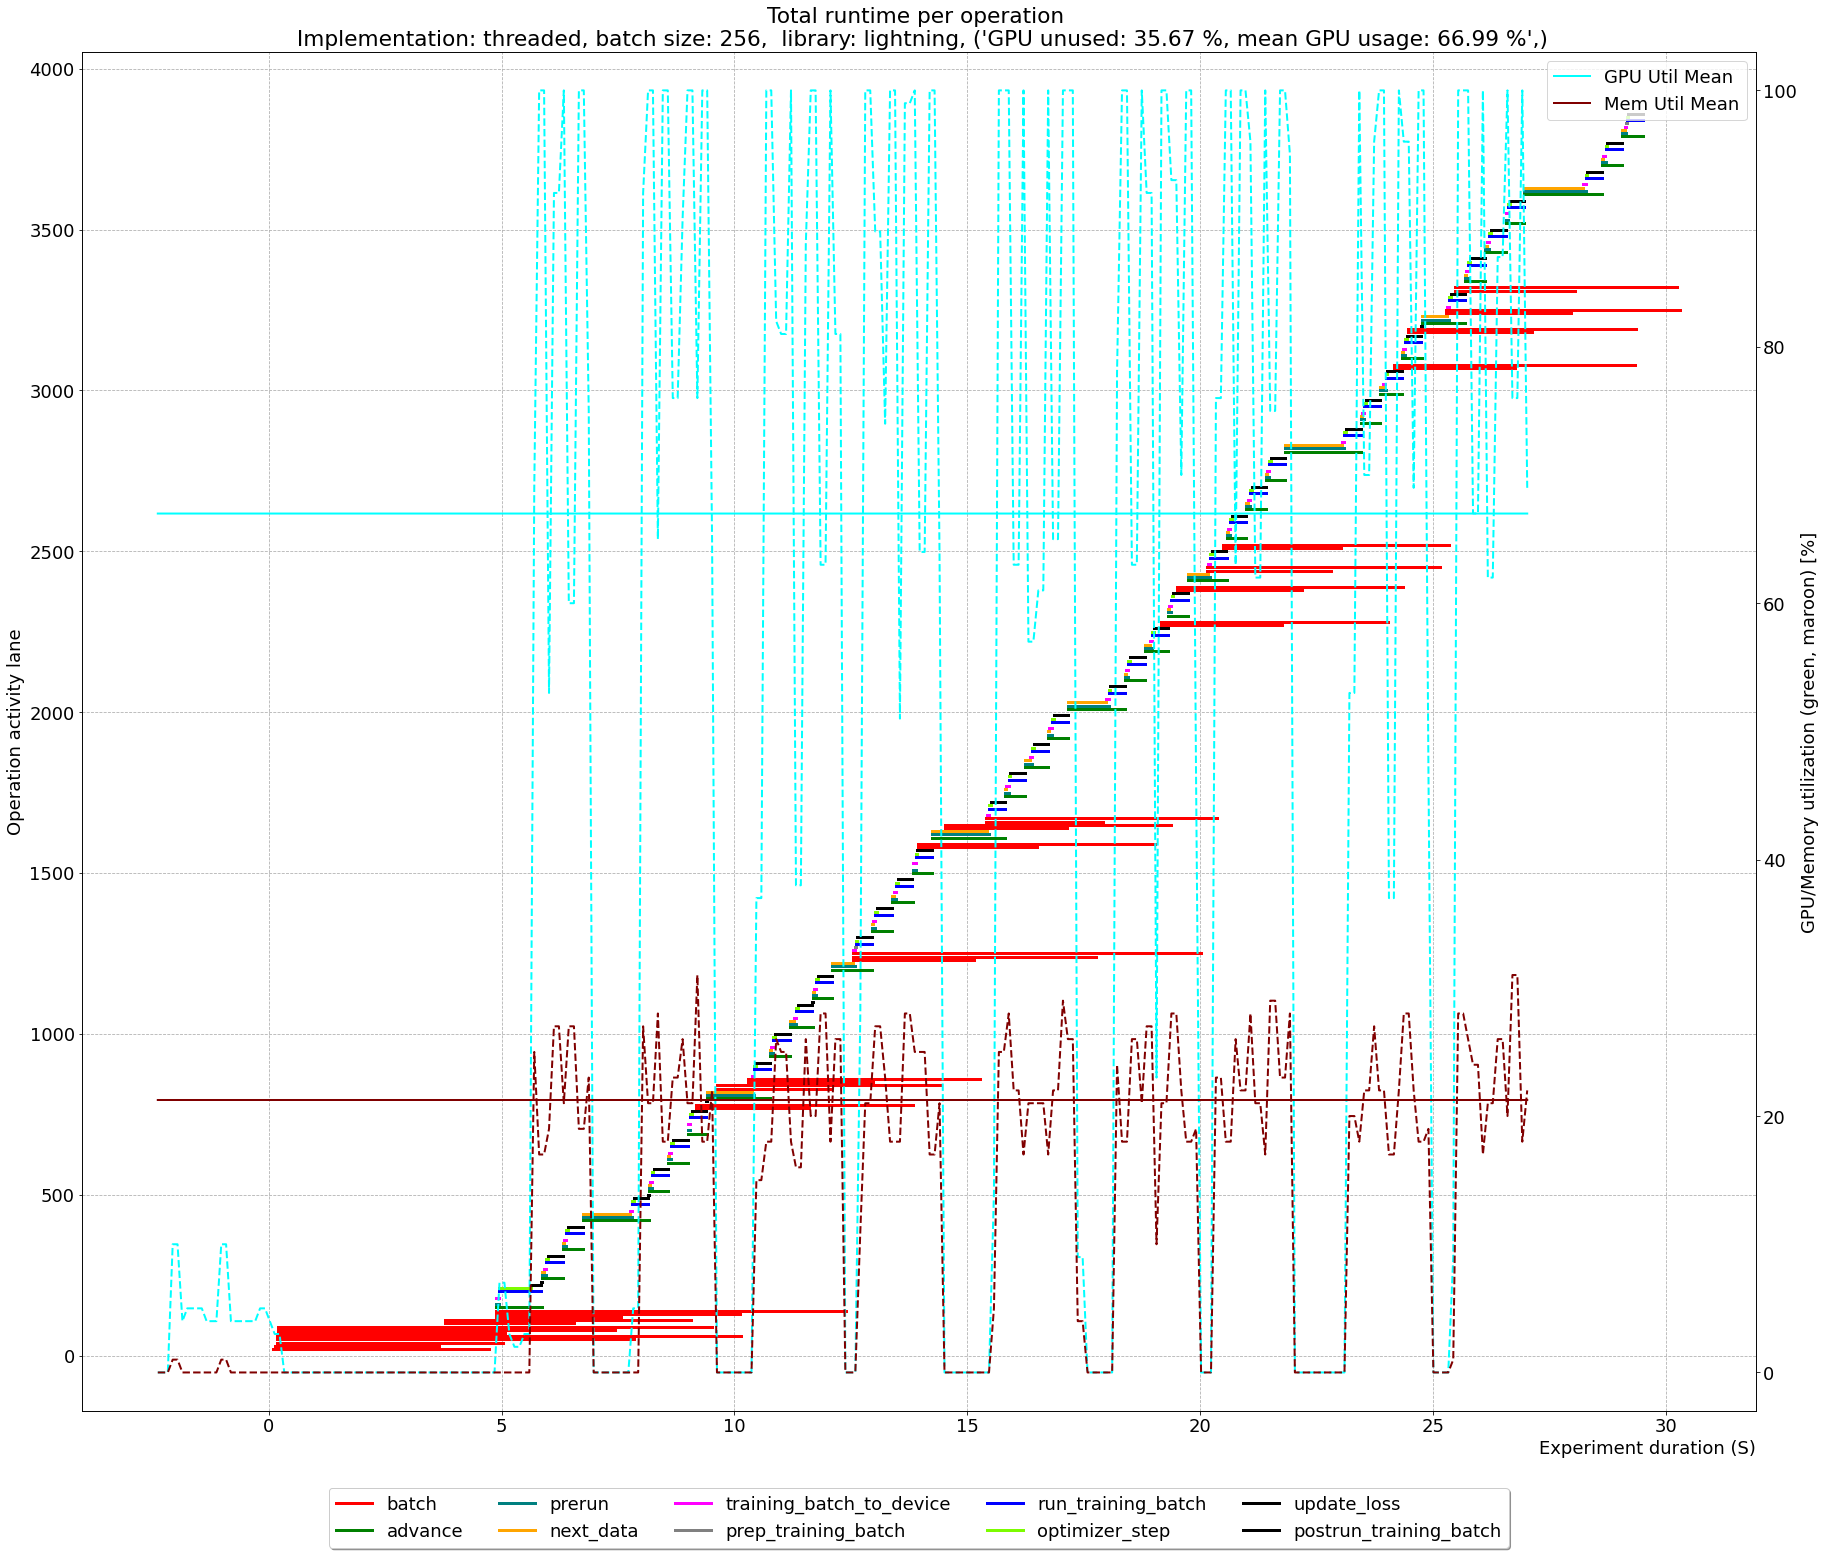

timestamp_2 True
Printed: 113
75.45161290322581 43.15652173913043


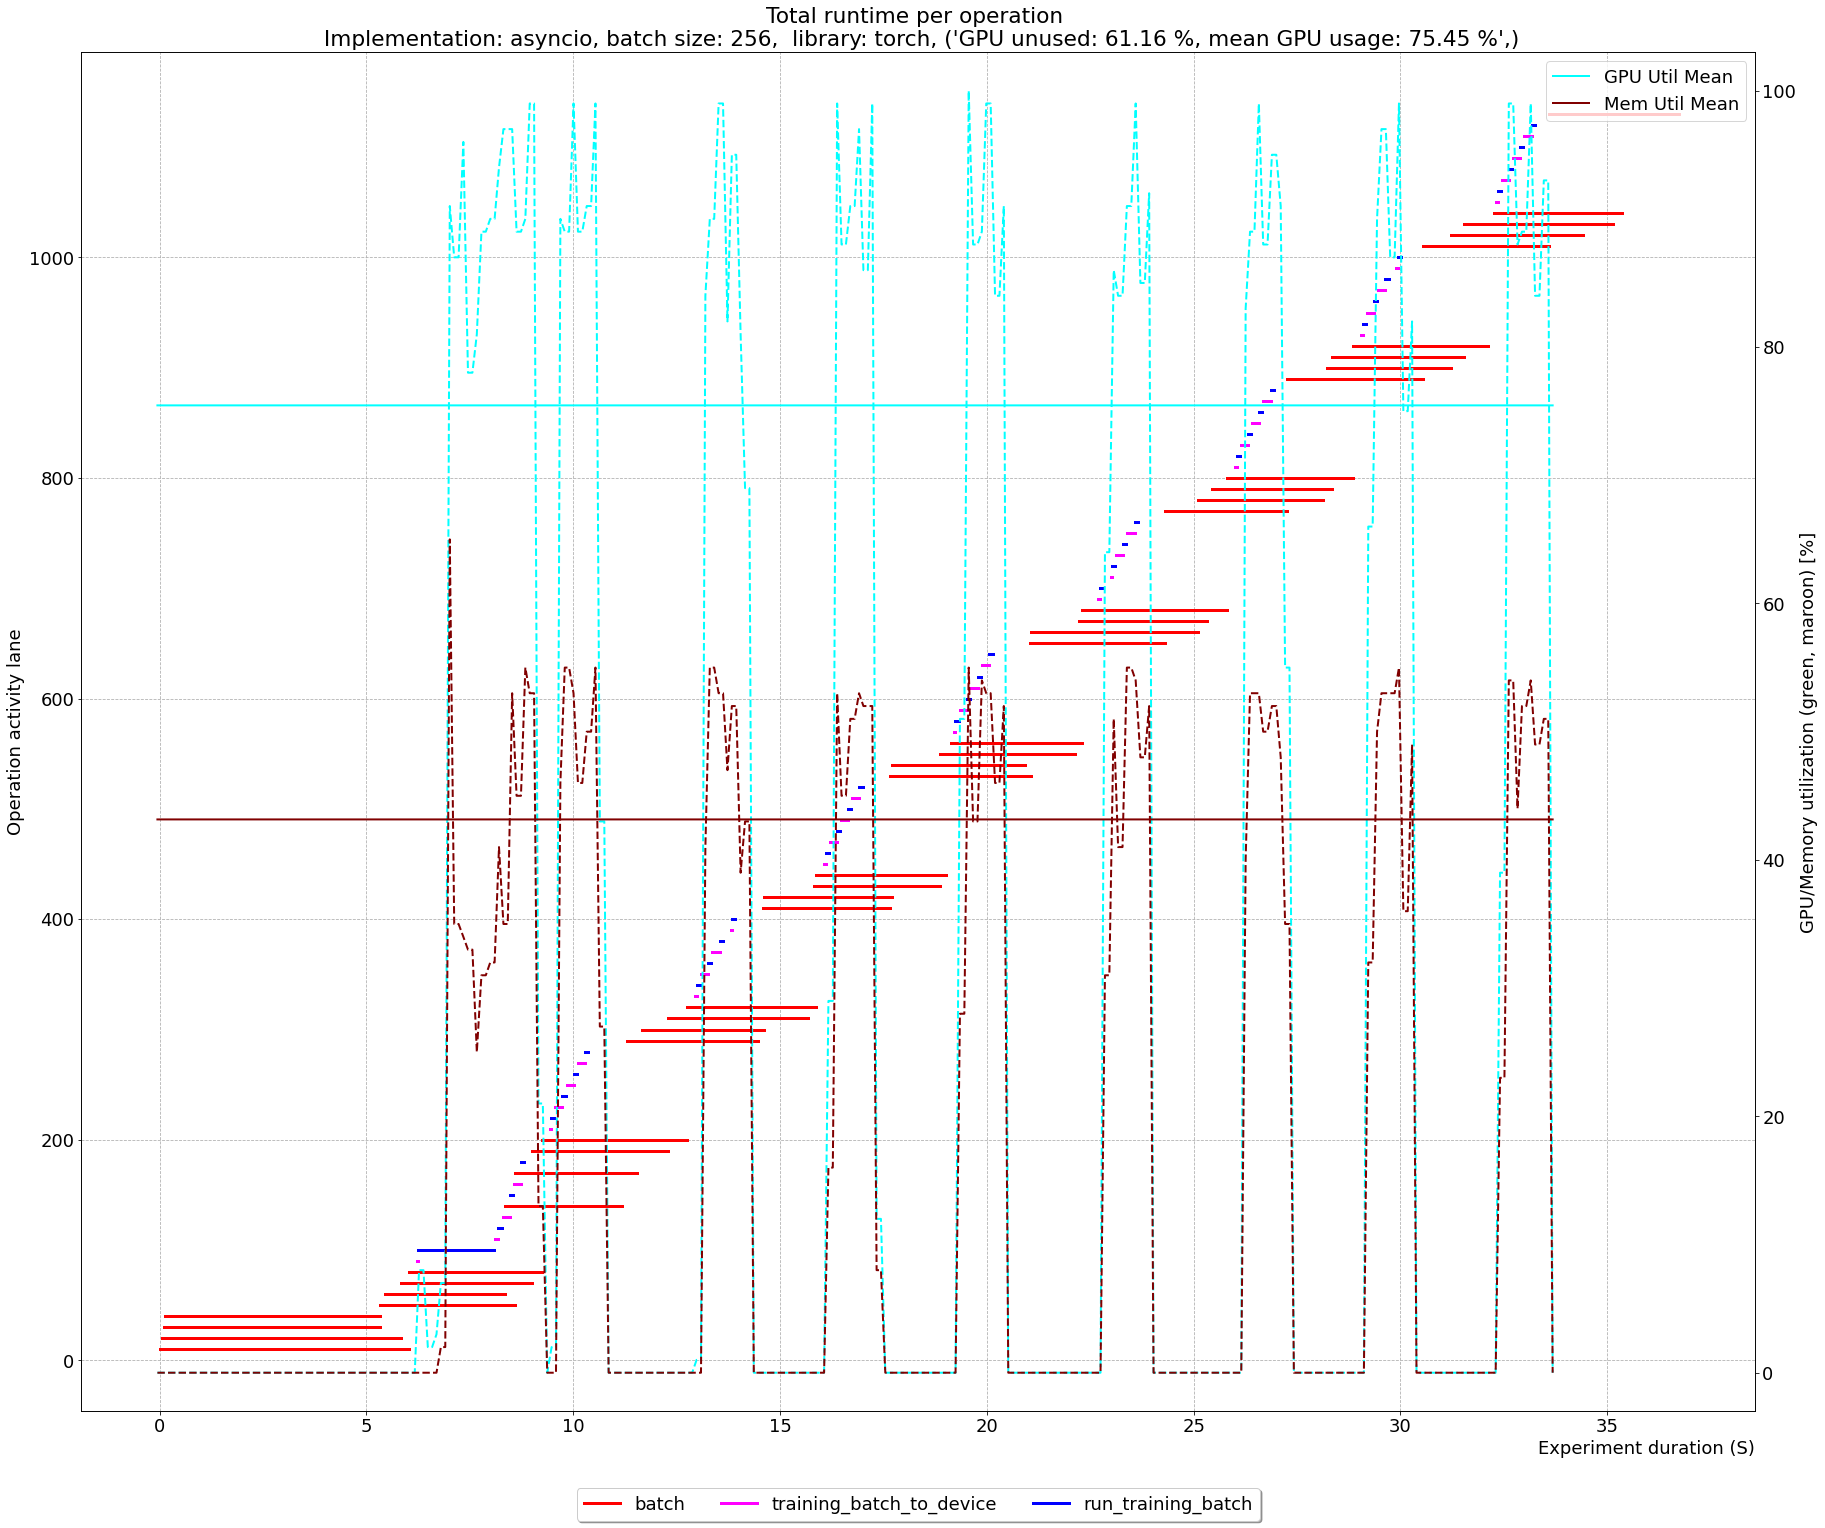

timestamp_2 True
Printed: 403
62.513888888888886 20.931428571428572


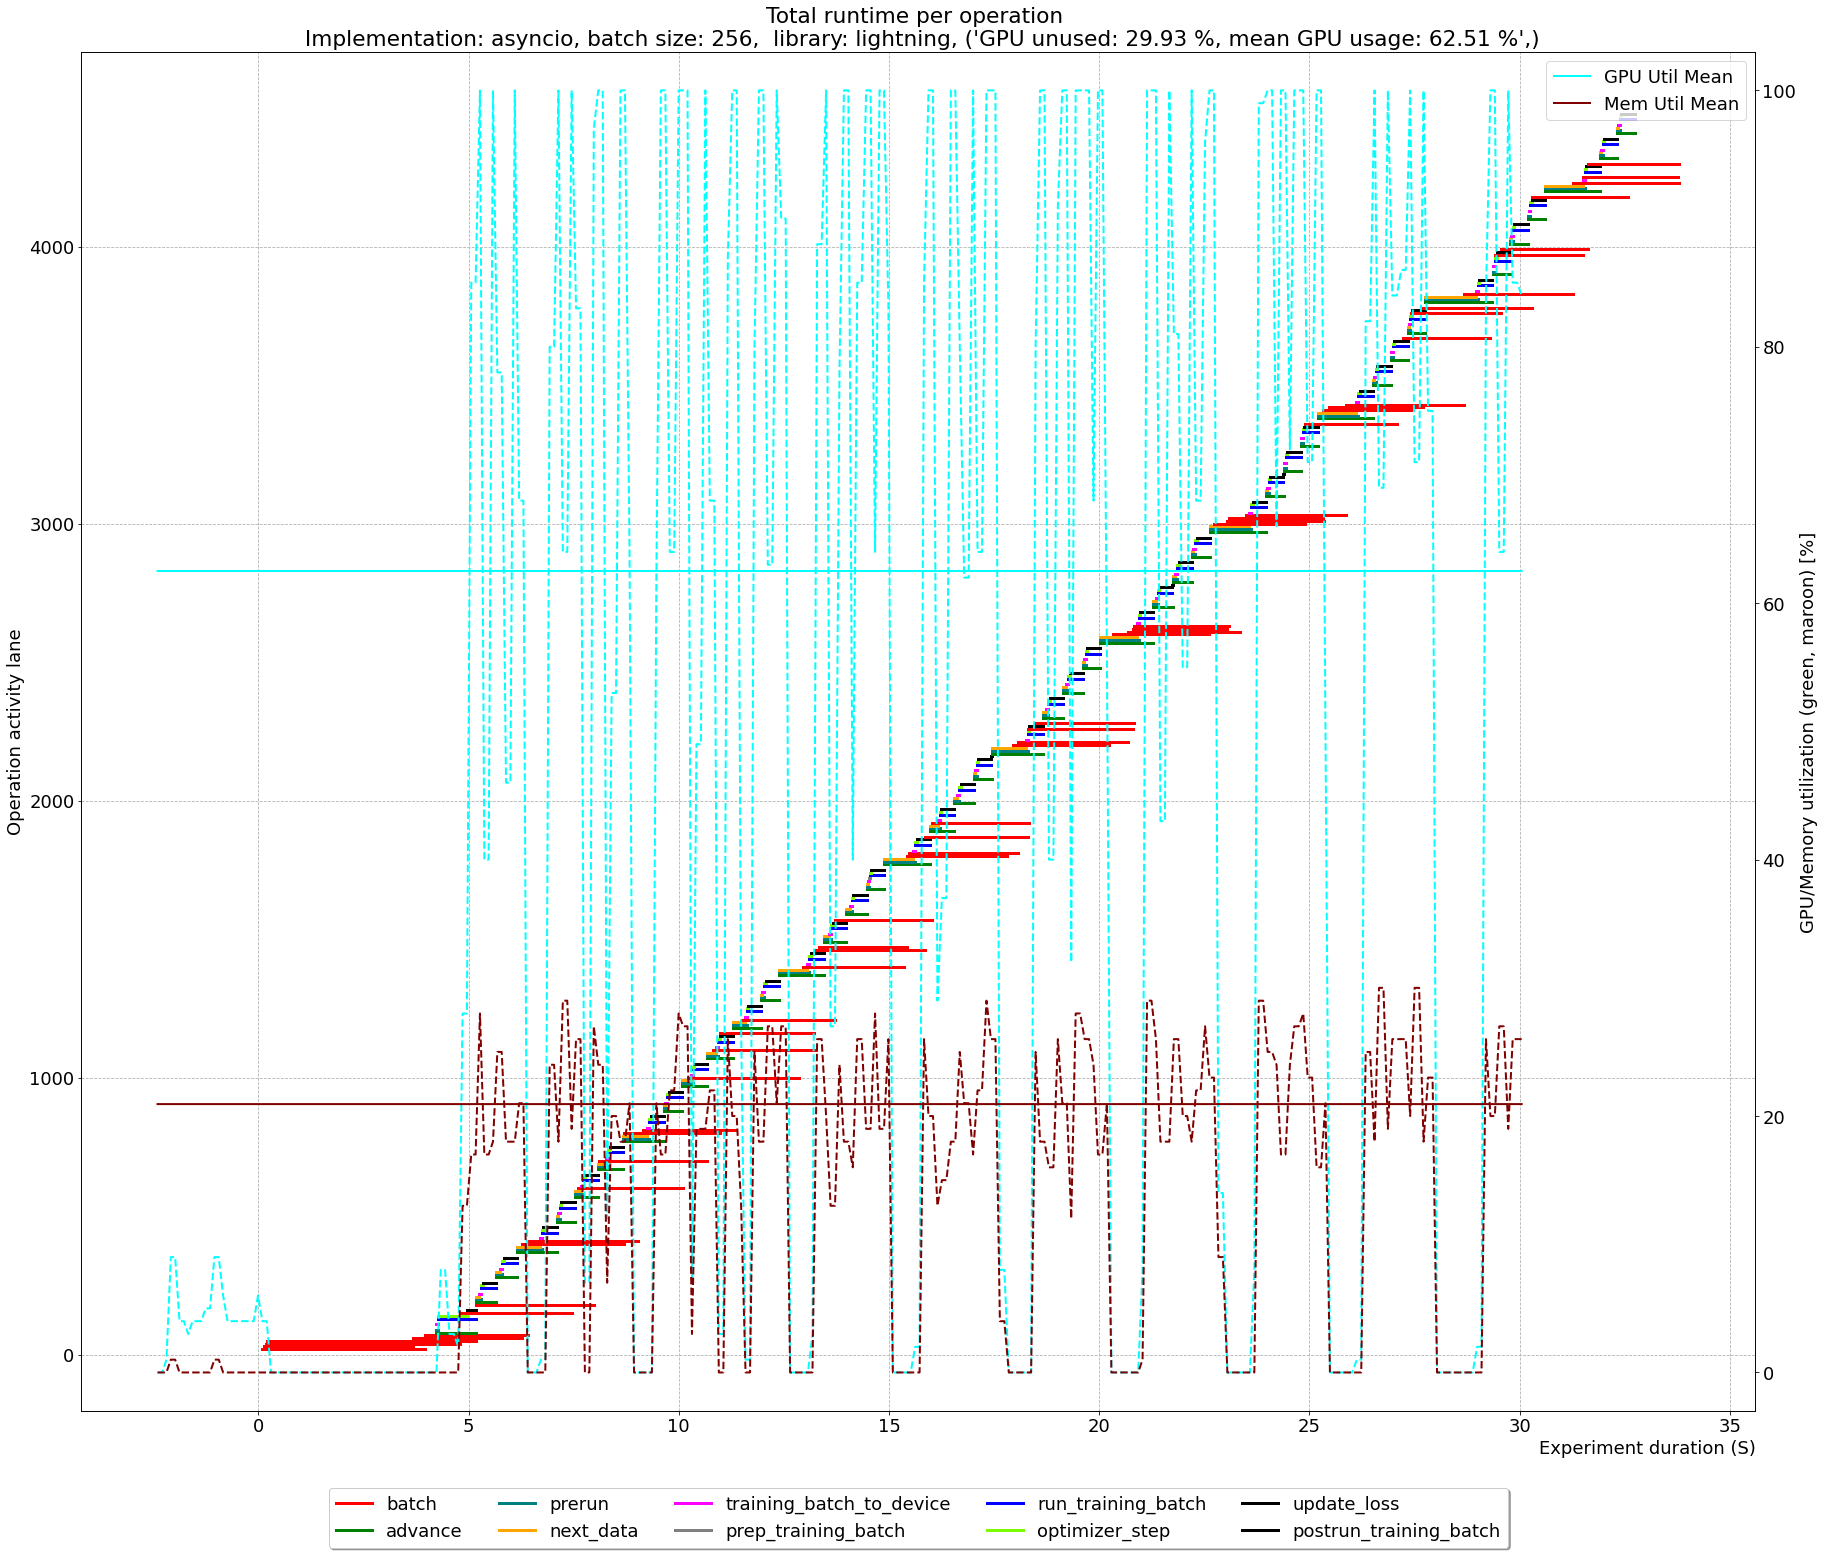

timestamp_2 True
Printed: 124
72.20863309352518 44.57936507936508


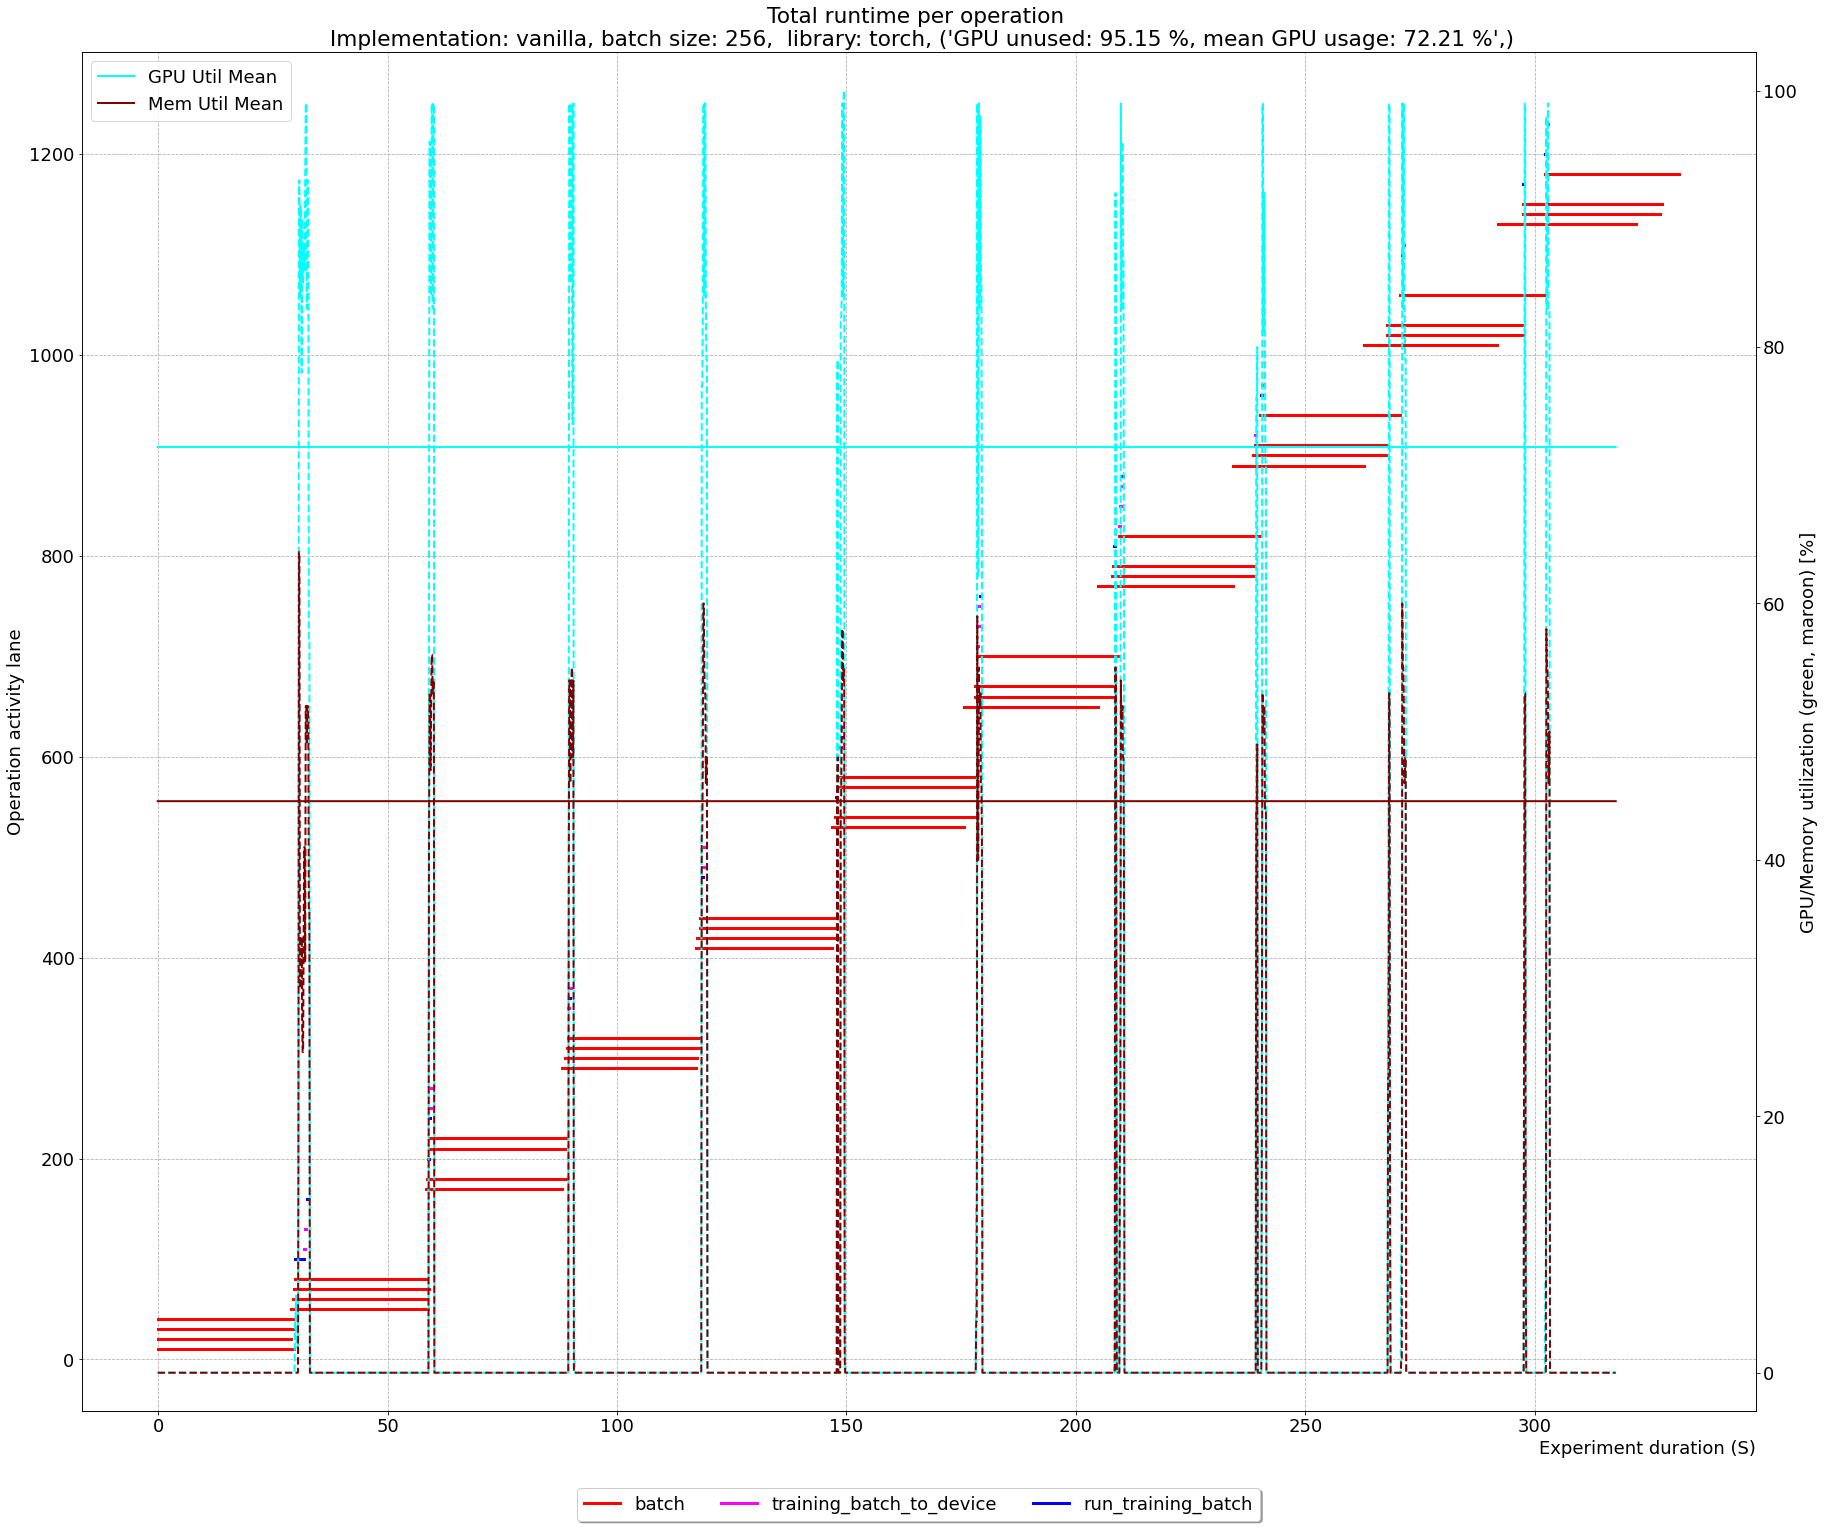

timestamp_2 True
Printed: 401
57.16858237547893 19.395238095238096


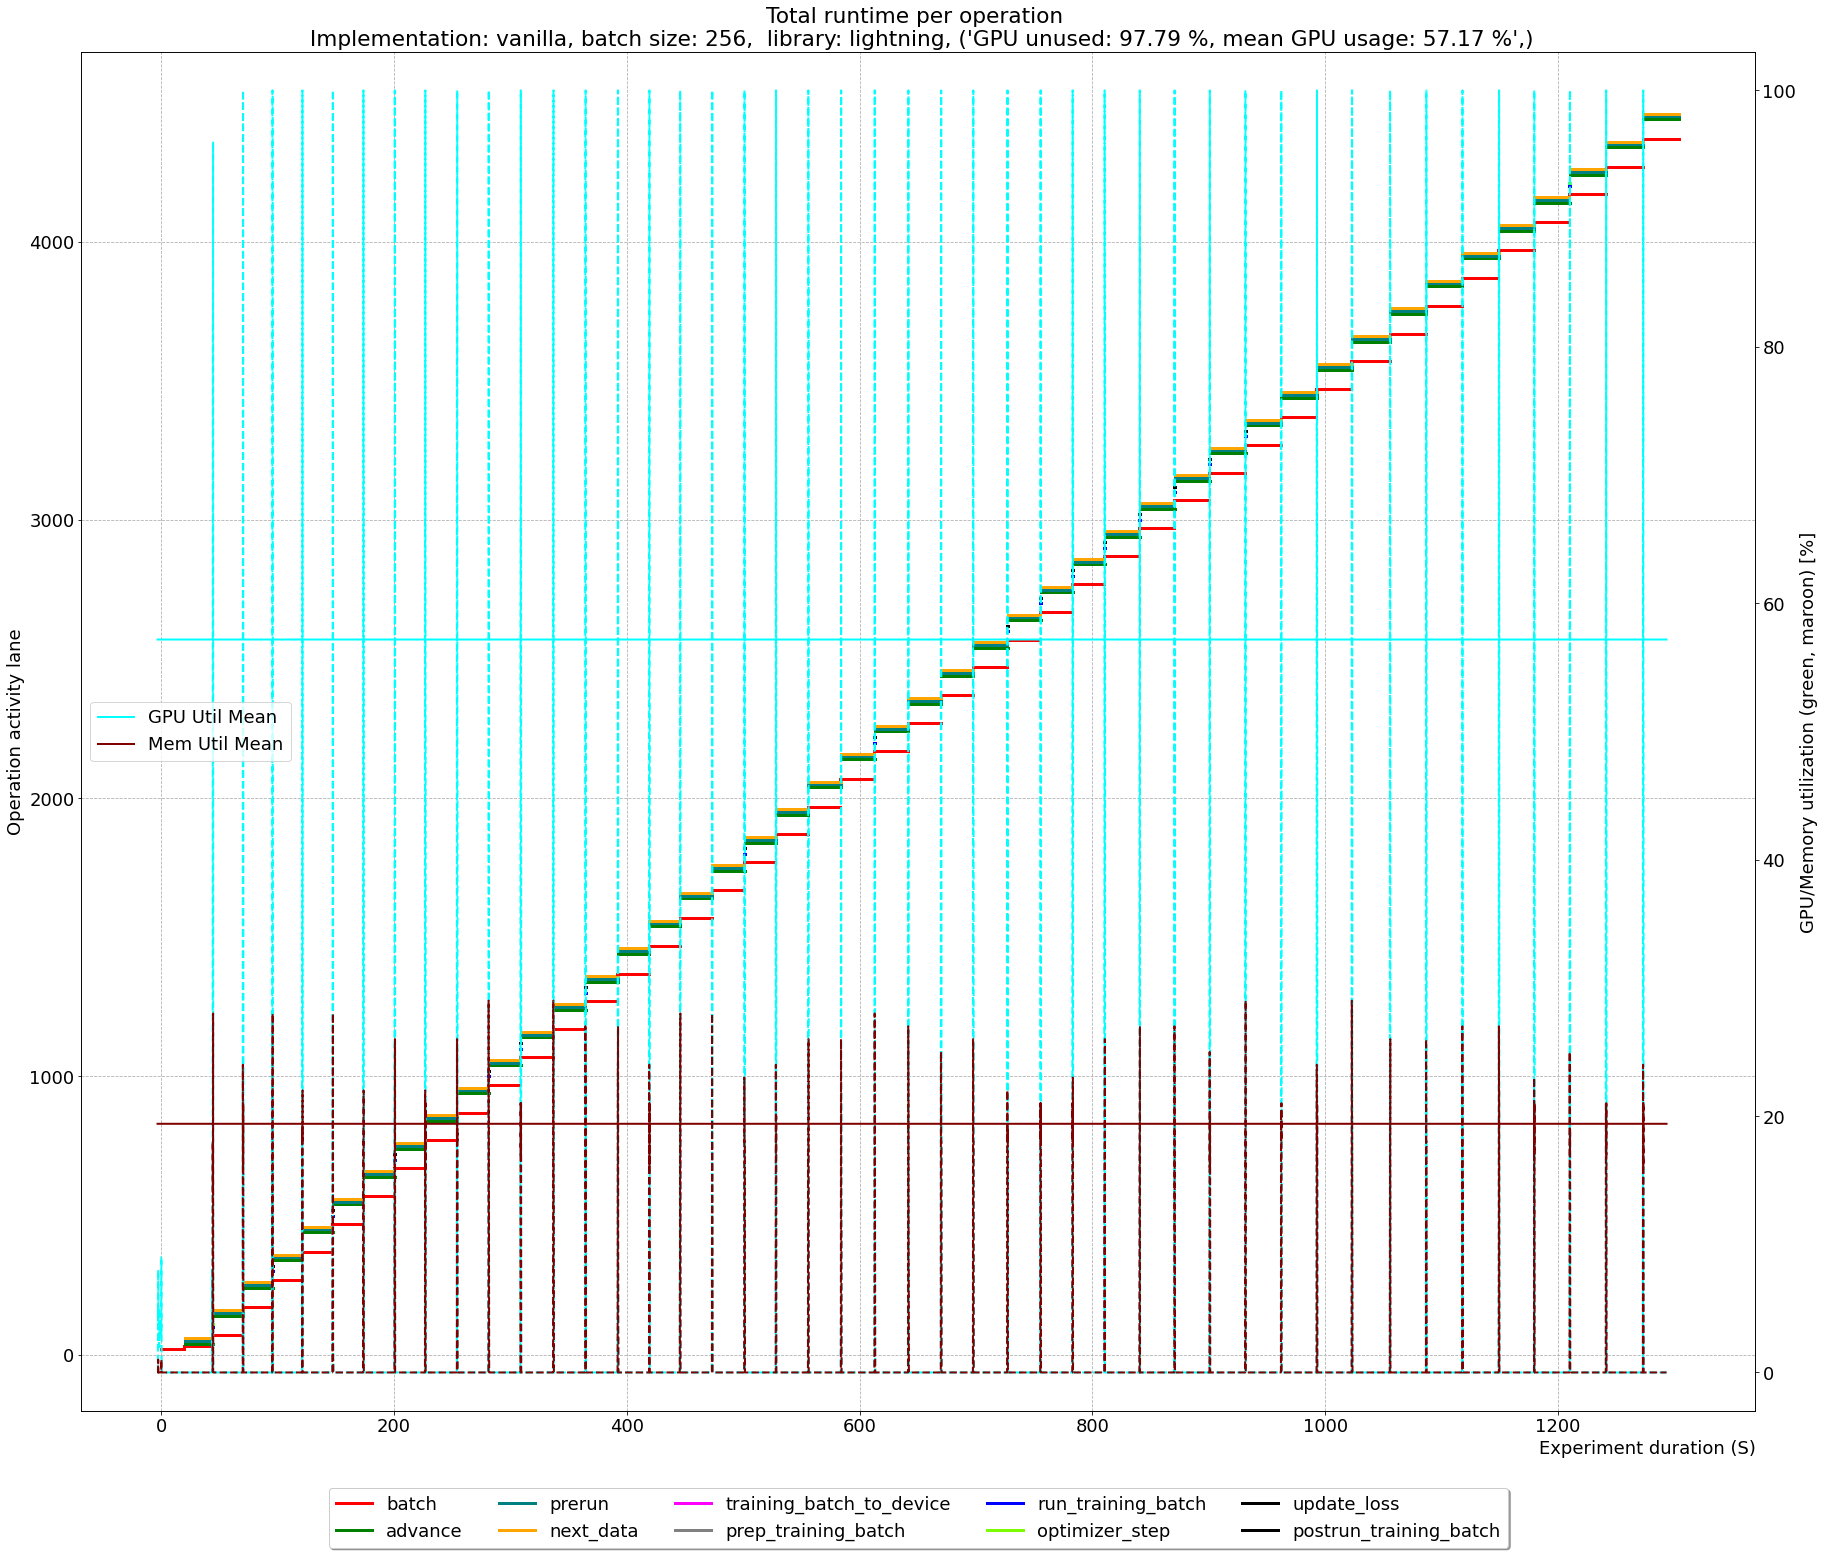

In [42]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
print(unique_functions)
returns_s3 = []

for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False)
    result = show_timelines_with_gpu2(df=df, gpu_util=dfgpu, lanes=lanes, colors=colors, run=run, 
                                     flat=False, show_gpu=True, zoom=True, zoom_epochs=3,
                                     skip_plot=False, ms=True)
    df = df_dataloader_s3[(df_dataloader_s3["item_x"]=="run_training_batch")&(df_dataloader_s3["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_calc"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_s3[(df_dataloader_s3["item_x"]=="training_batch_to_device")&(df_dataloader_s3["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_transf"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_s3[(df_dataloader_s3["item_x"]=="update_loss")&(df_dataloader_s3["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_update_loss"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_s3[(df_dataloader_s3["item_x"]=="optimizer_step")&(df_dataloader_s3["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_optimizer_step"] = (df["end_time_y"] - df["start_time_x"]).sum()
    result["run"]=run
    returns_s3.append(result)

['advance', 'next_data', 'optimizer_step', 'postrun_training_batch', 'prep_training_batch', 'prerun', 'reset_timeline', 'update_loss', 'batch', 'training_batch_to_device', 'run_training_batch']
timestamp_2 True
Printed: 131
83.74590163934427 47.530434782608694


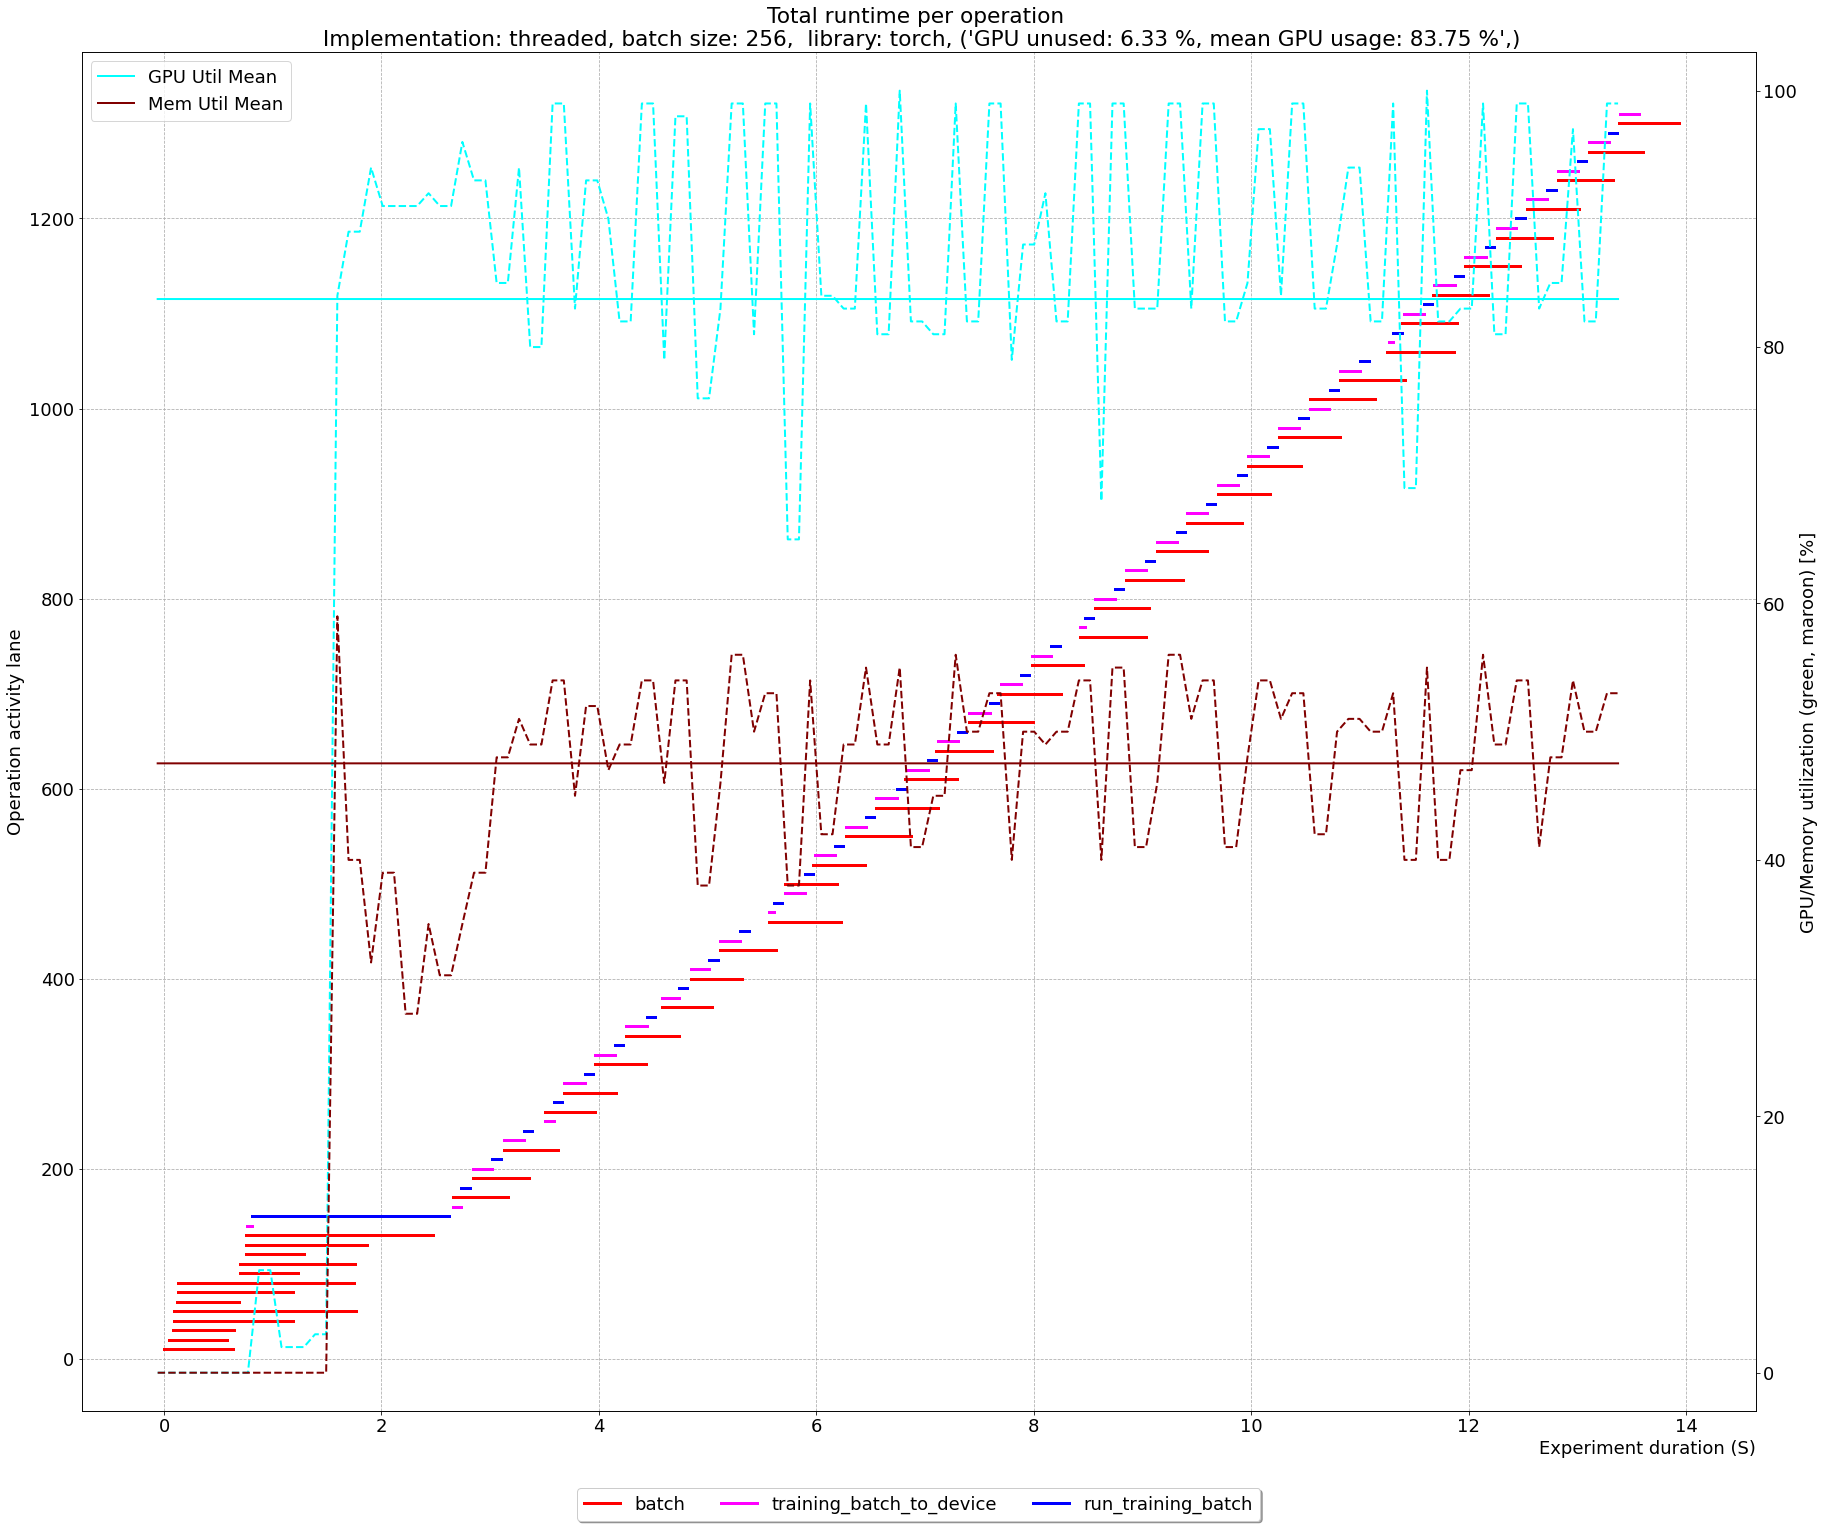

timestamp_2 True
Printed: 399
73.02285714285715 22.706666666666667


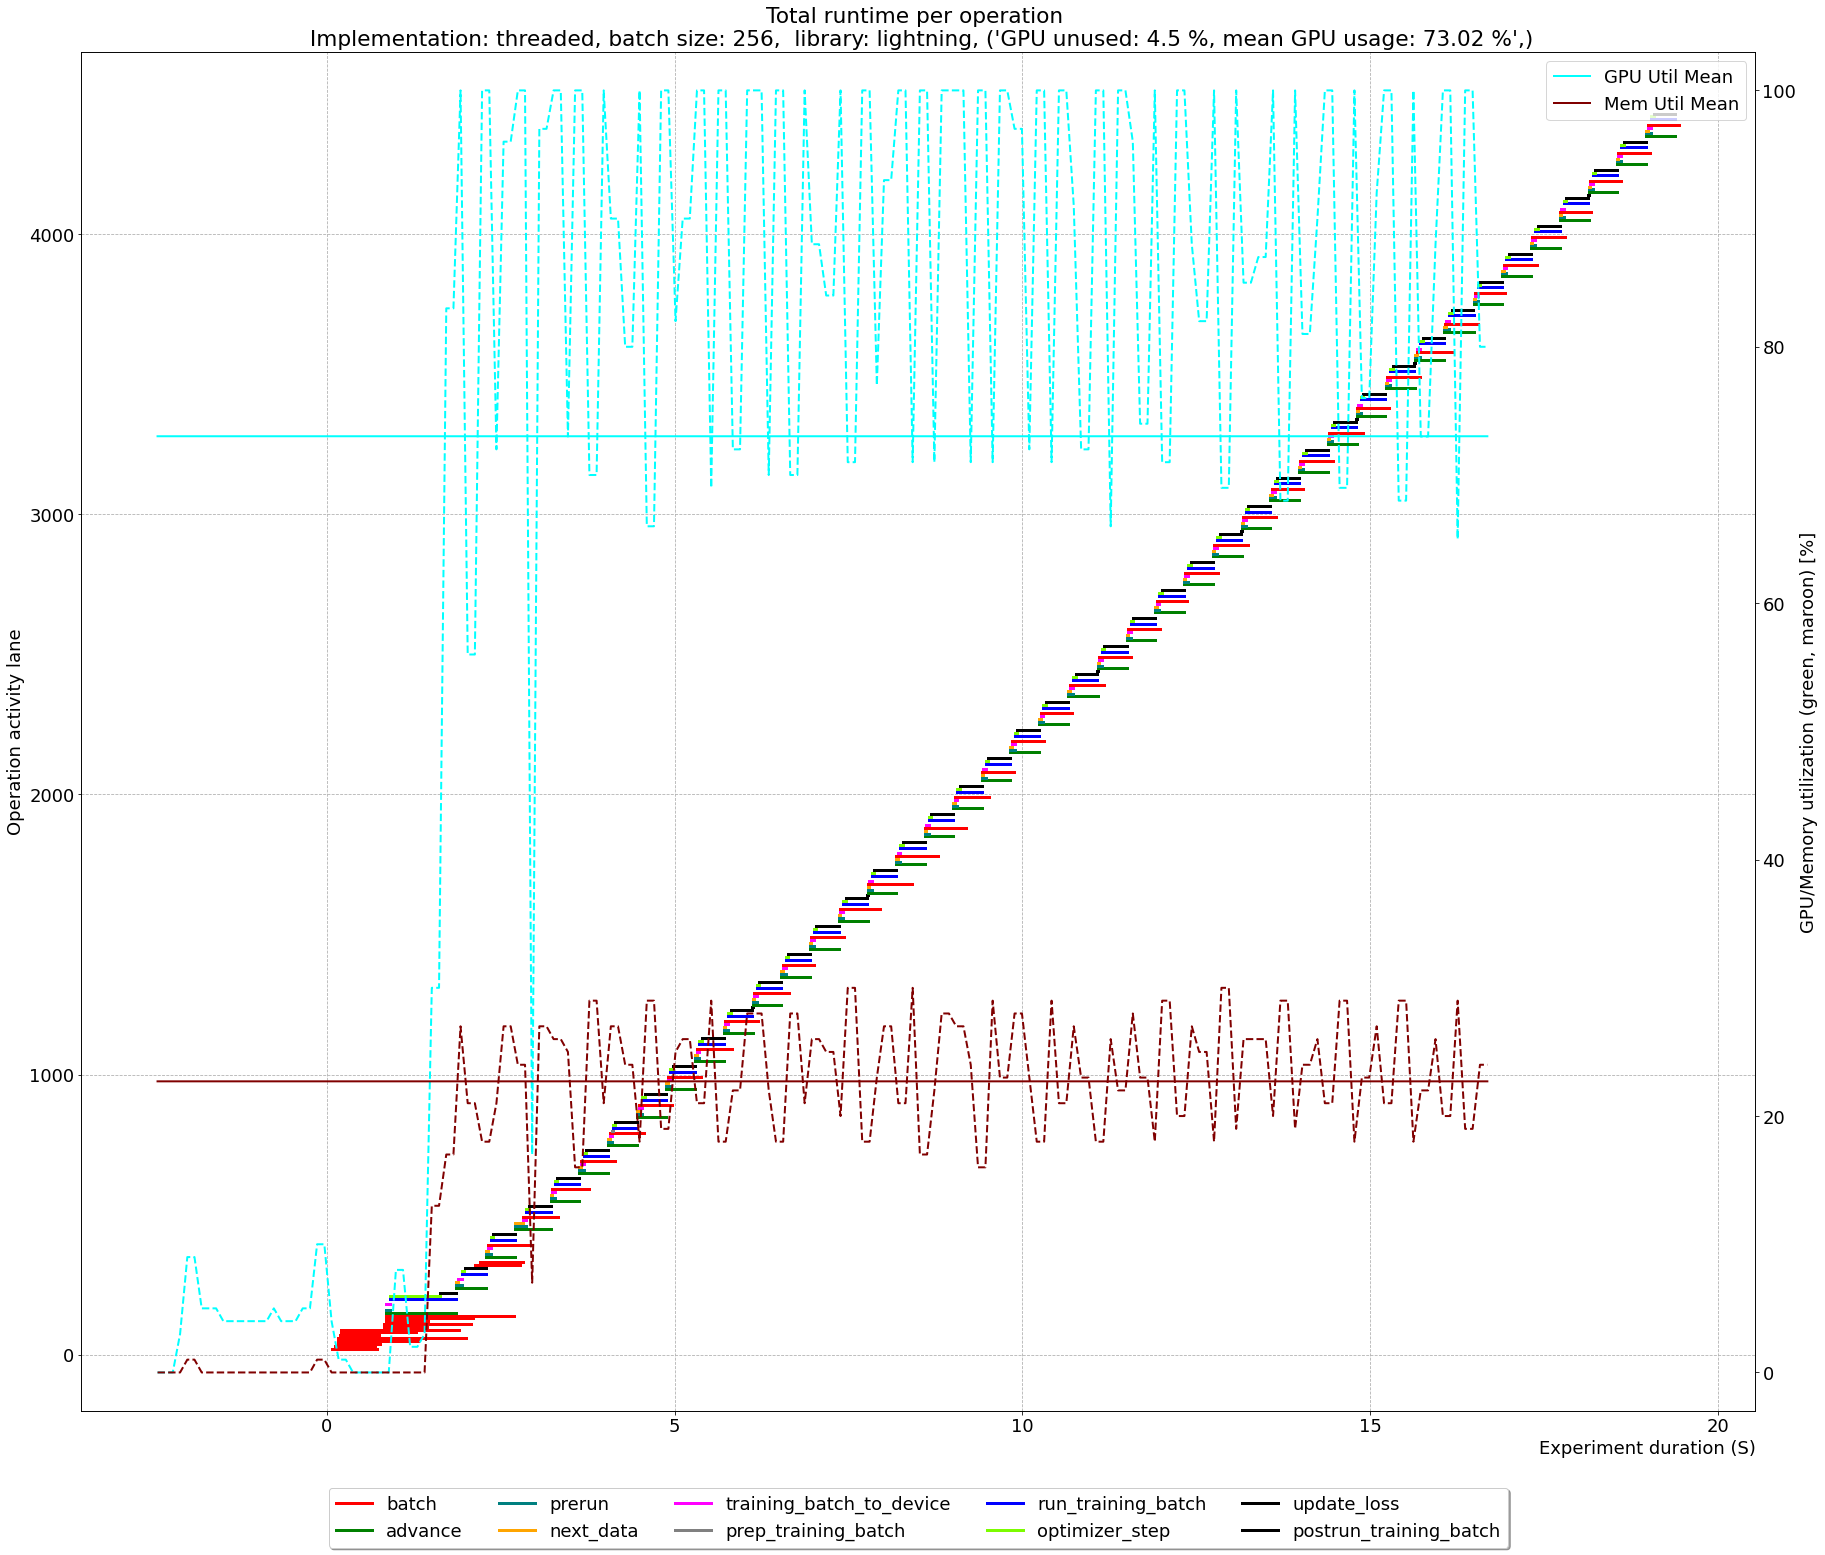

timestamp_2 True
Printed: 132
84.5040650406504 46.932203389830505


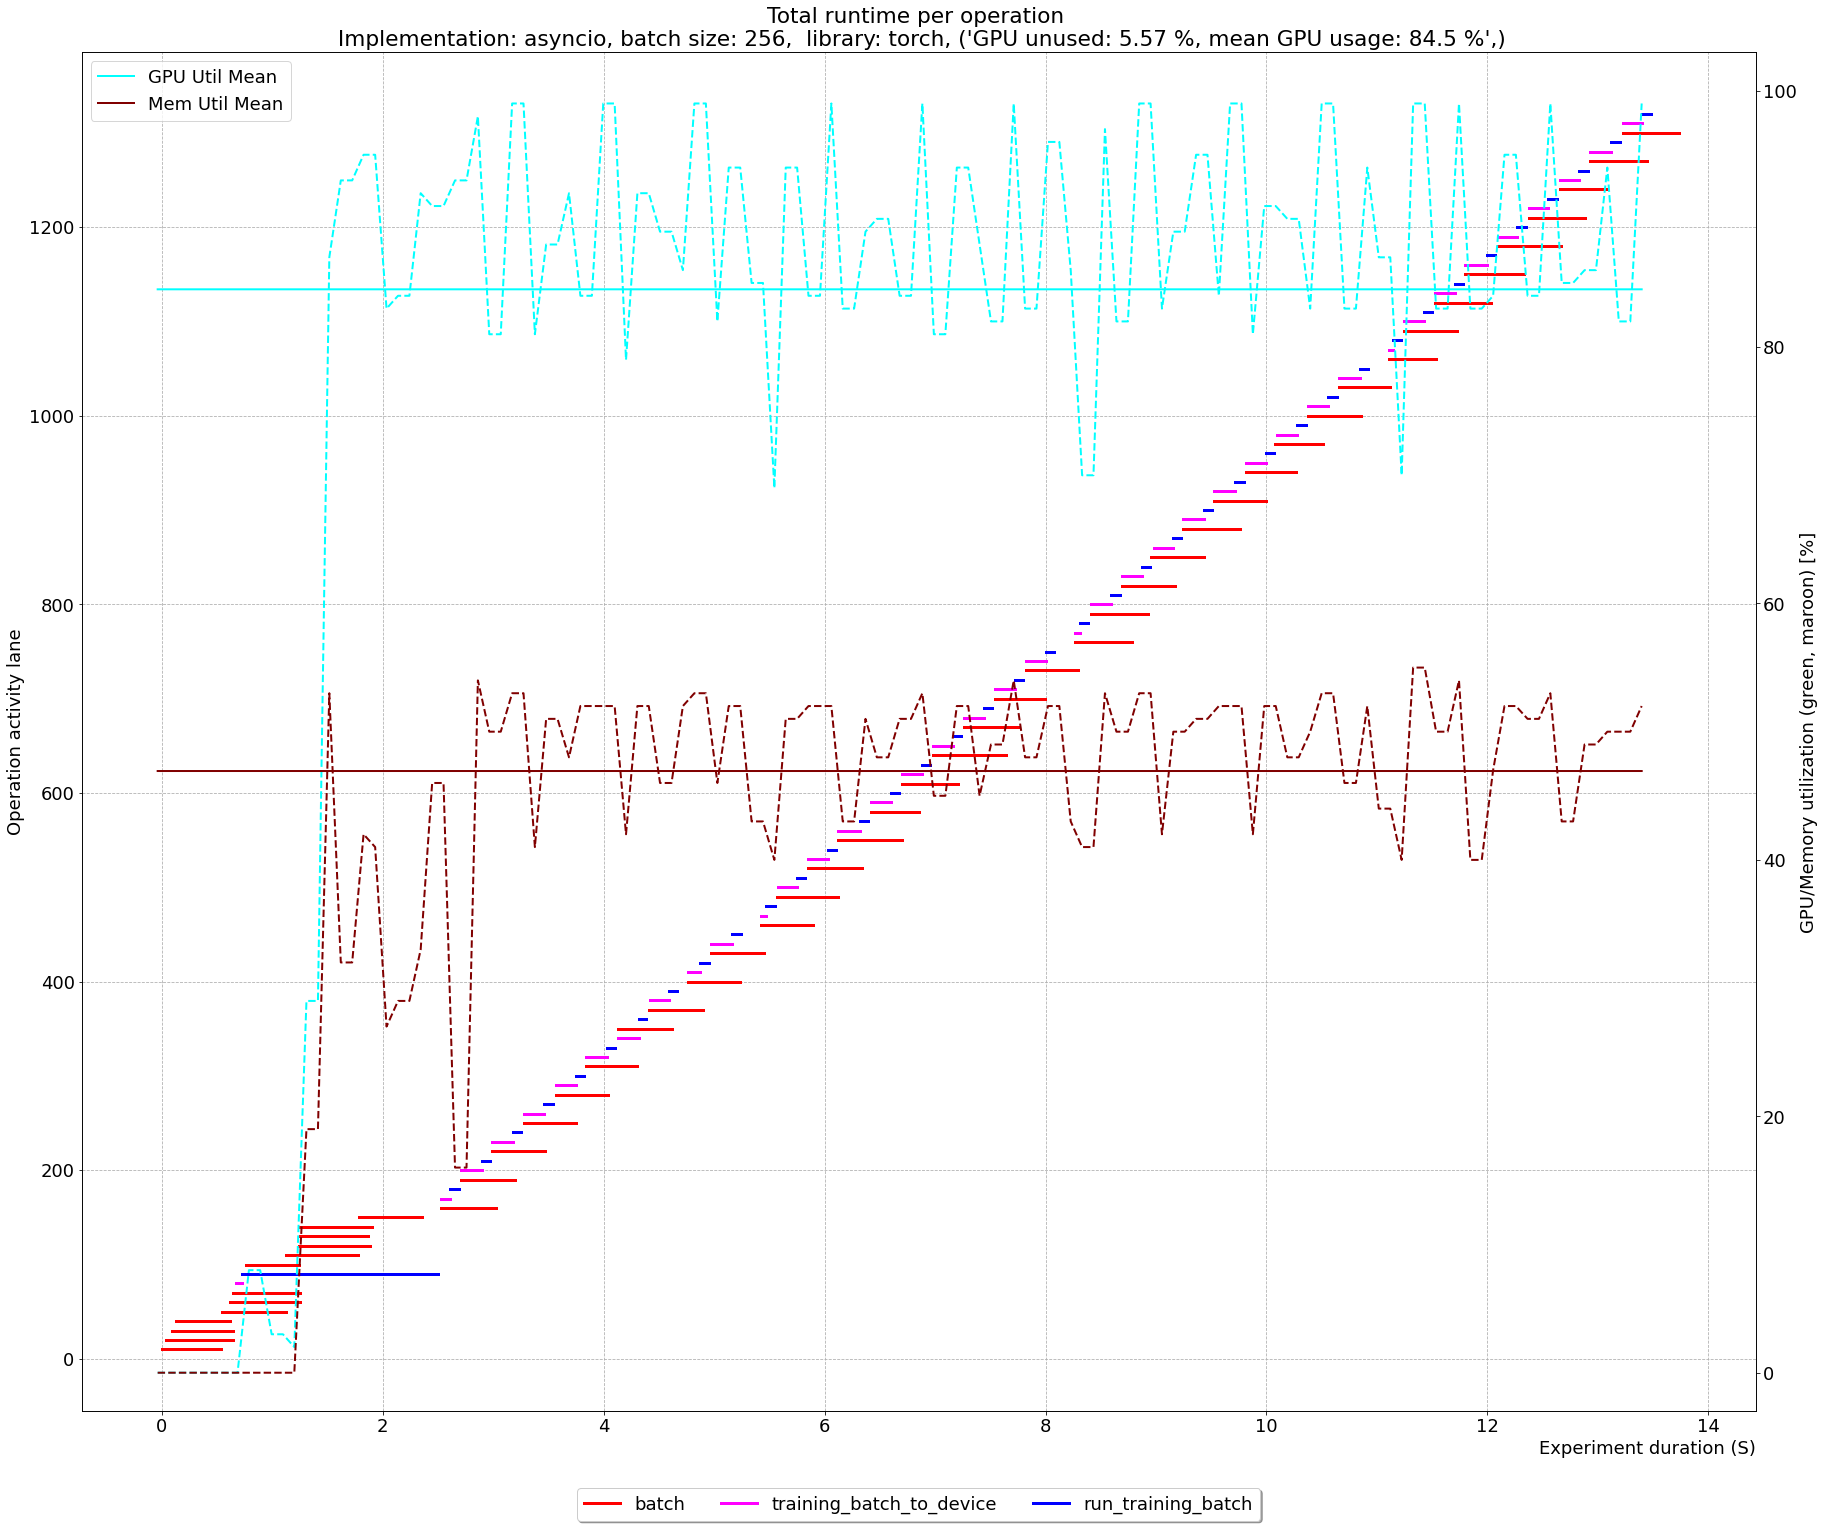

timestamp_2 True
Printed: 390
71.65168539325843 22.467105263157894


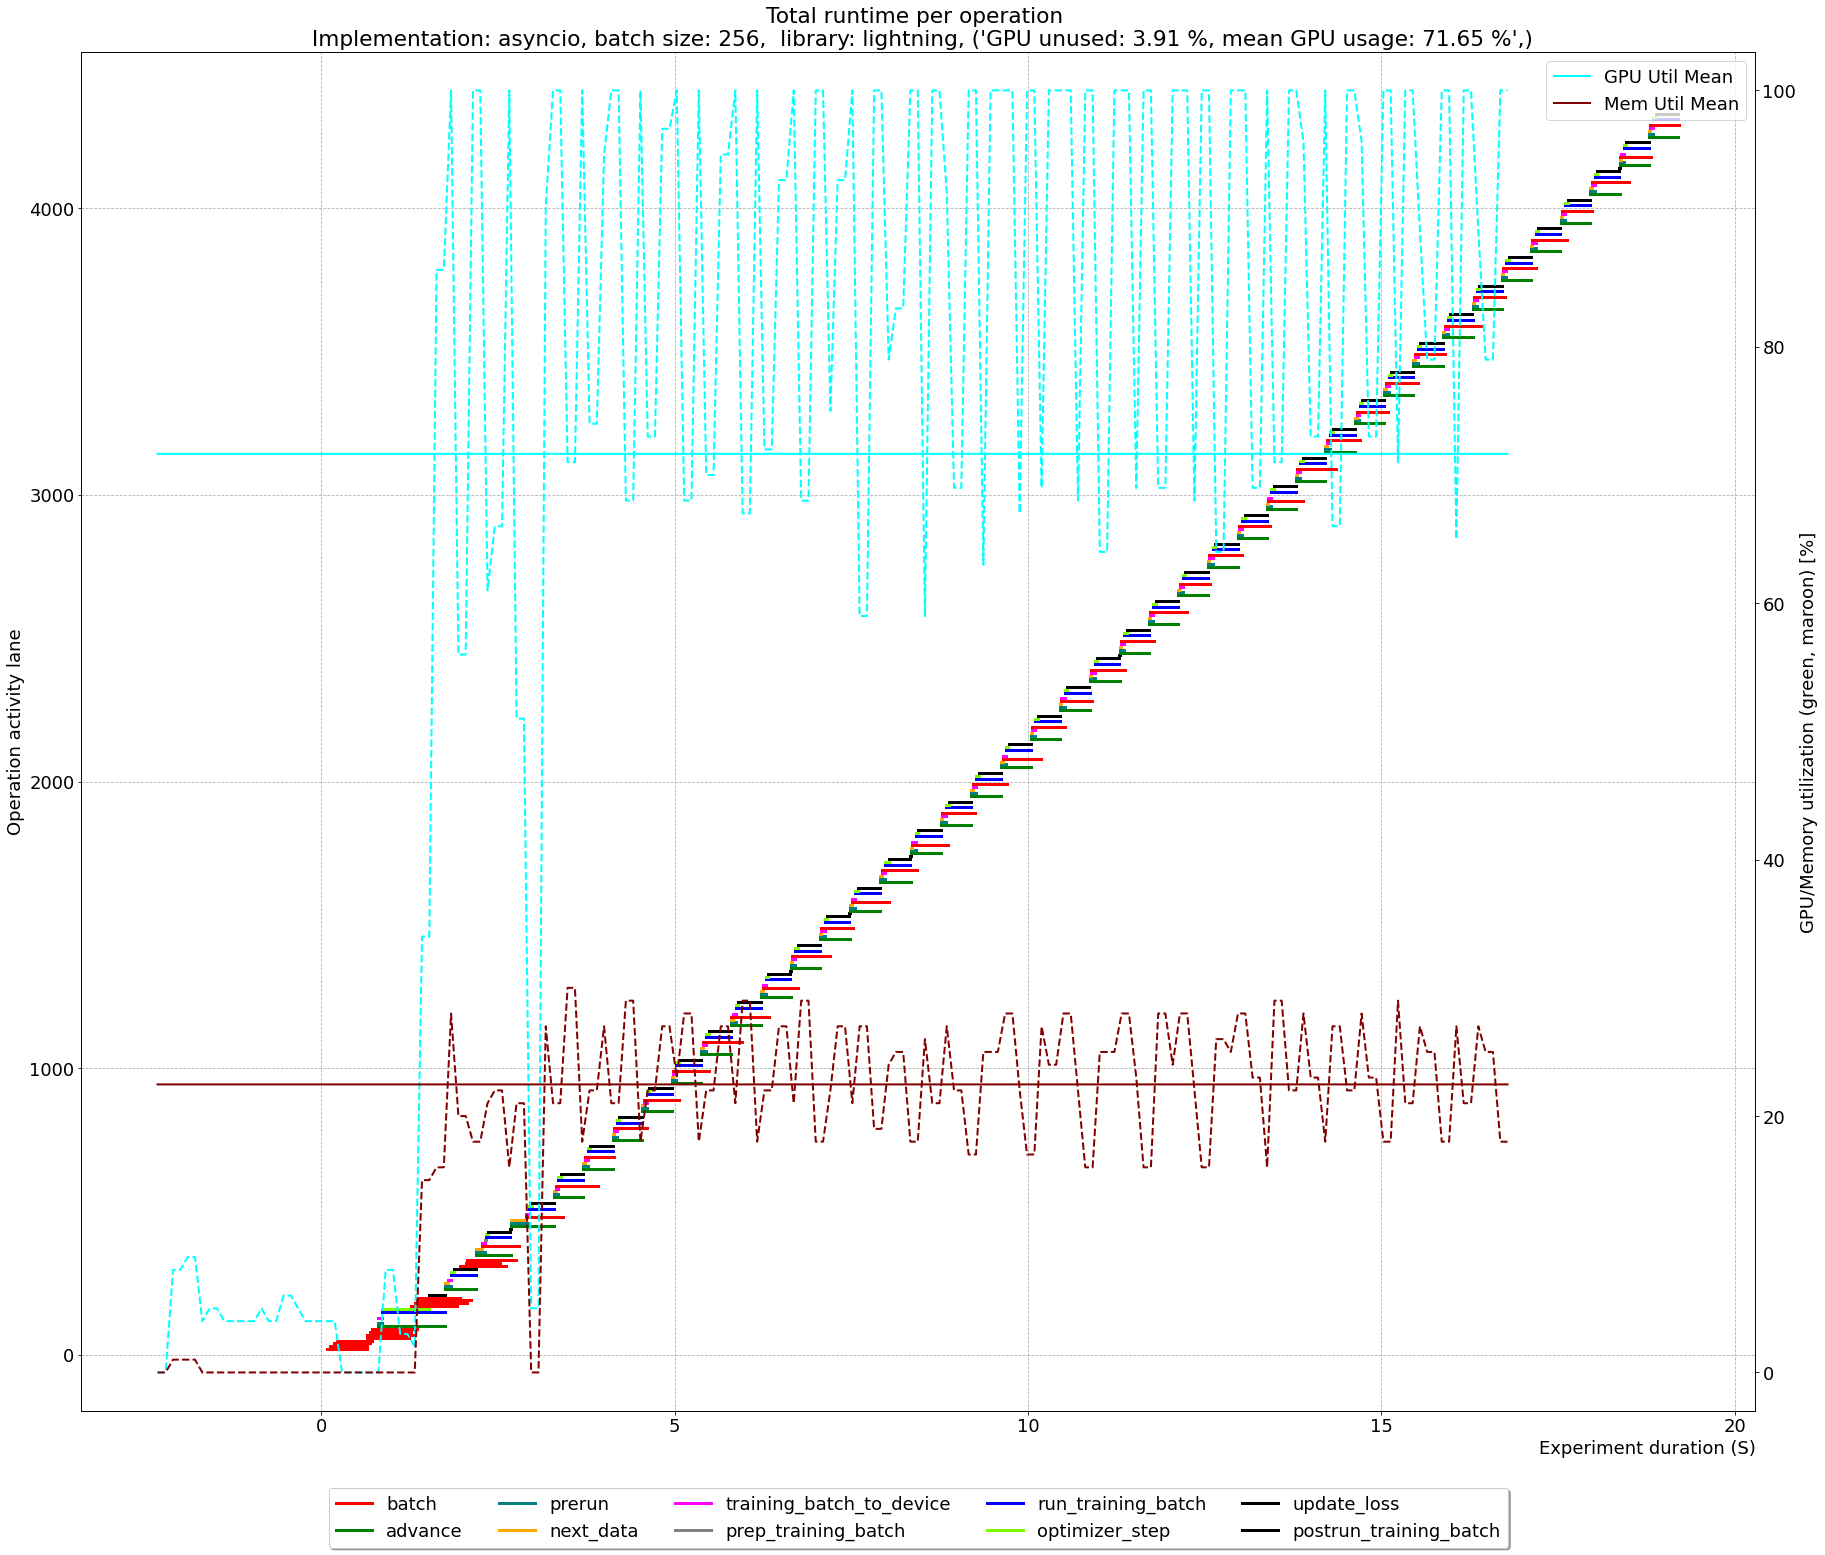

timestamp_2 True
Printed: 138
82.45112781954887 45.578125


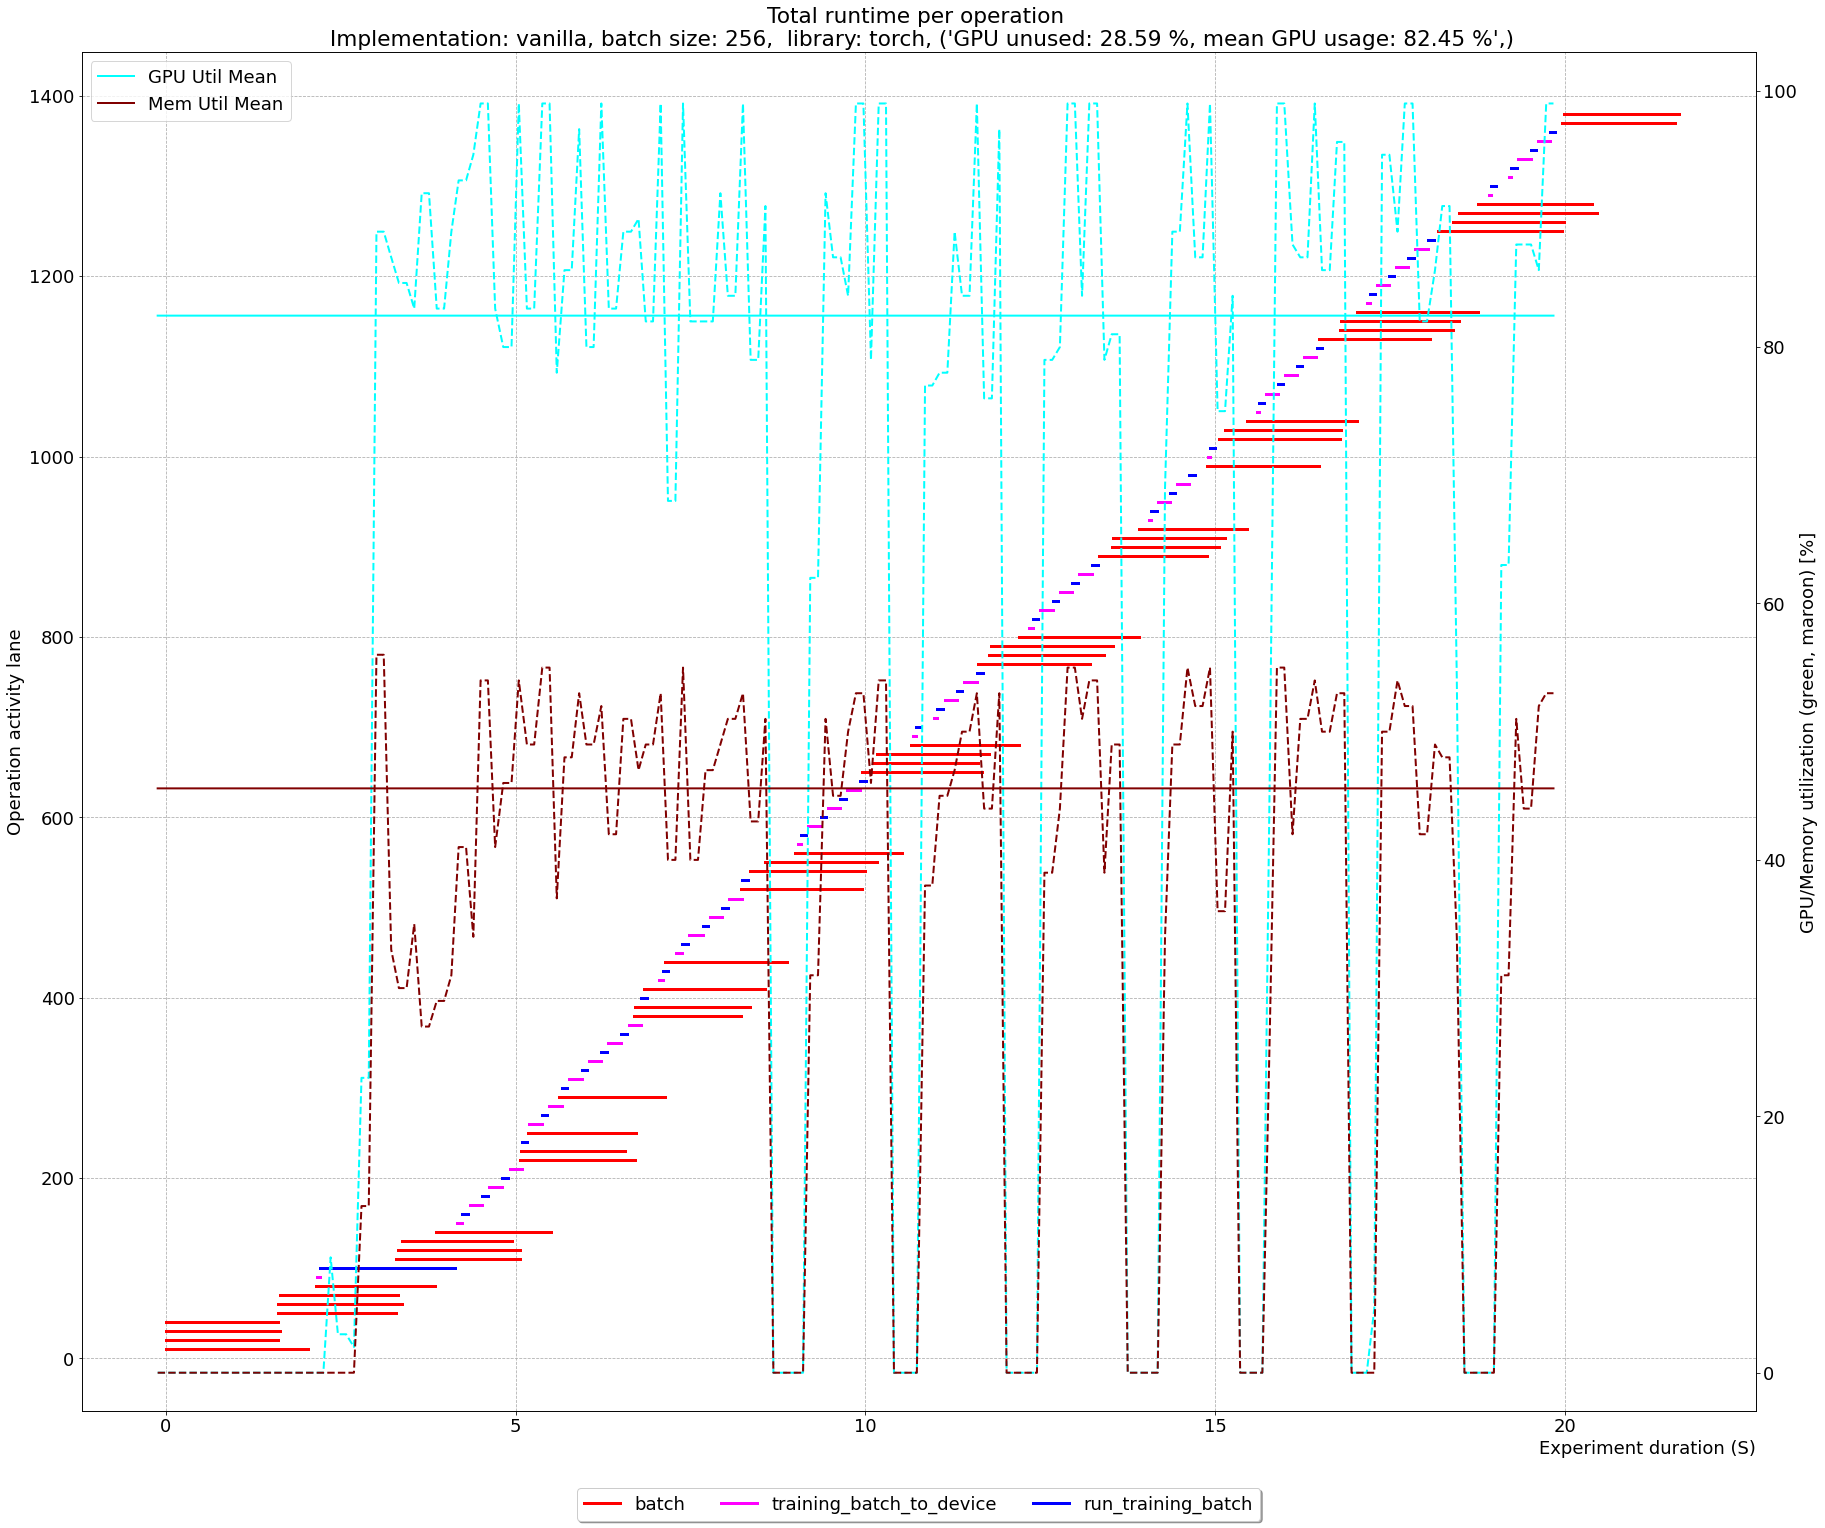

timestamp_2 True
Printed: 379
55.609243697478995 18.329896907216494


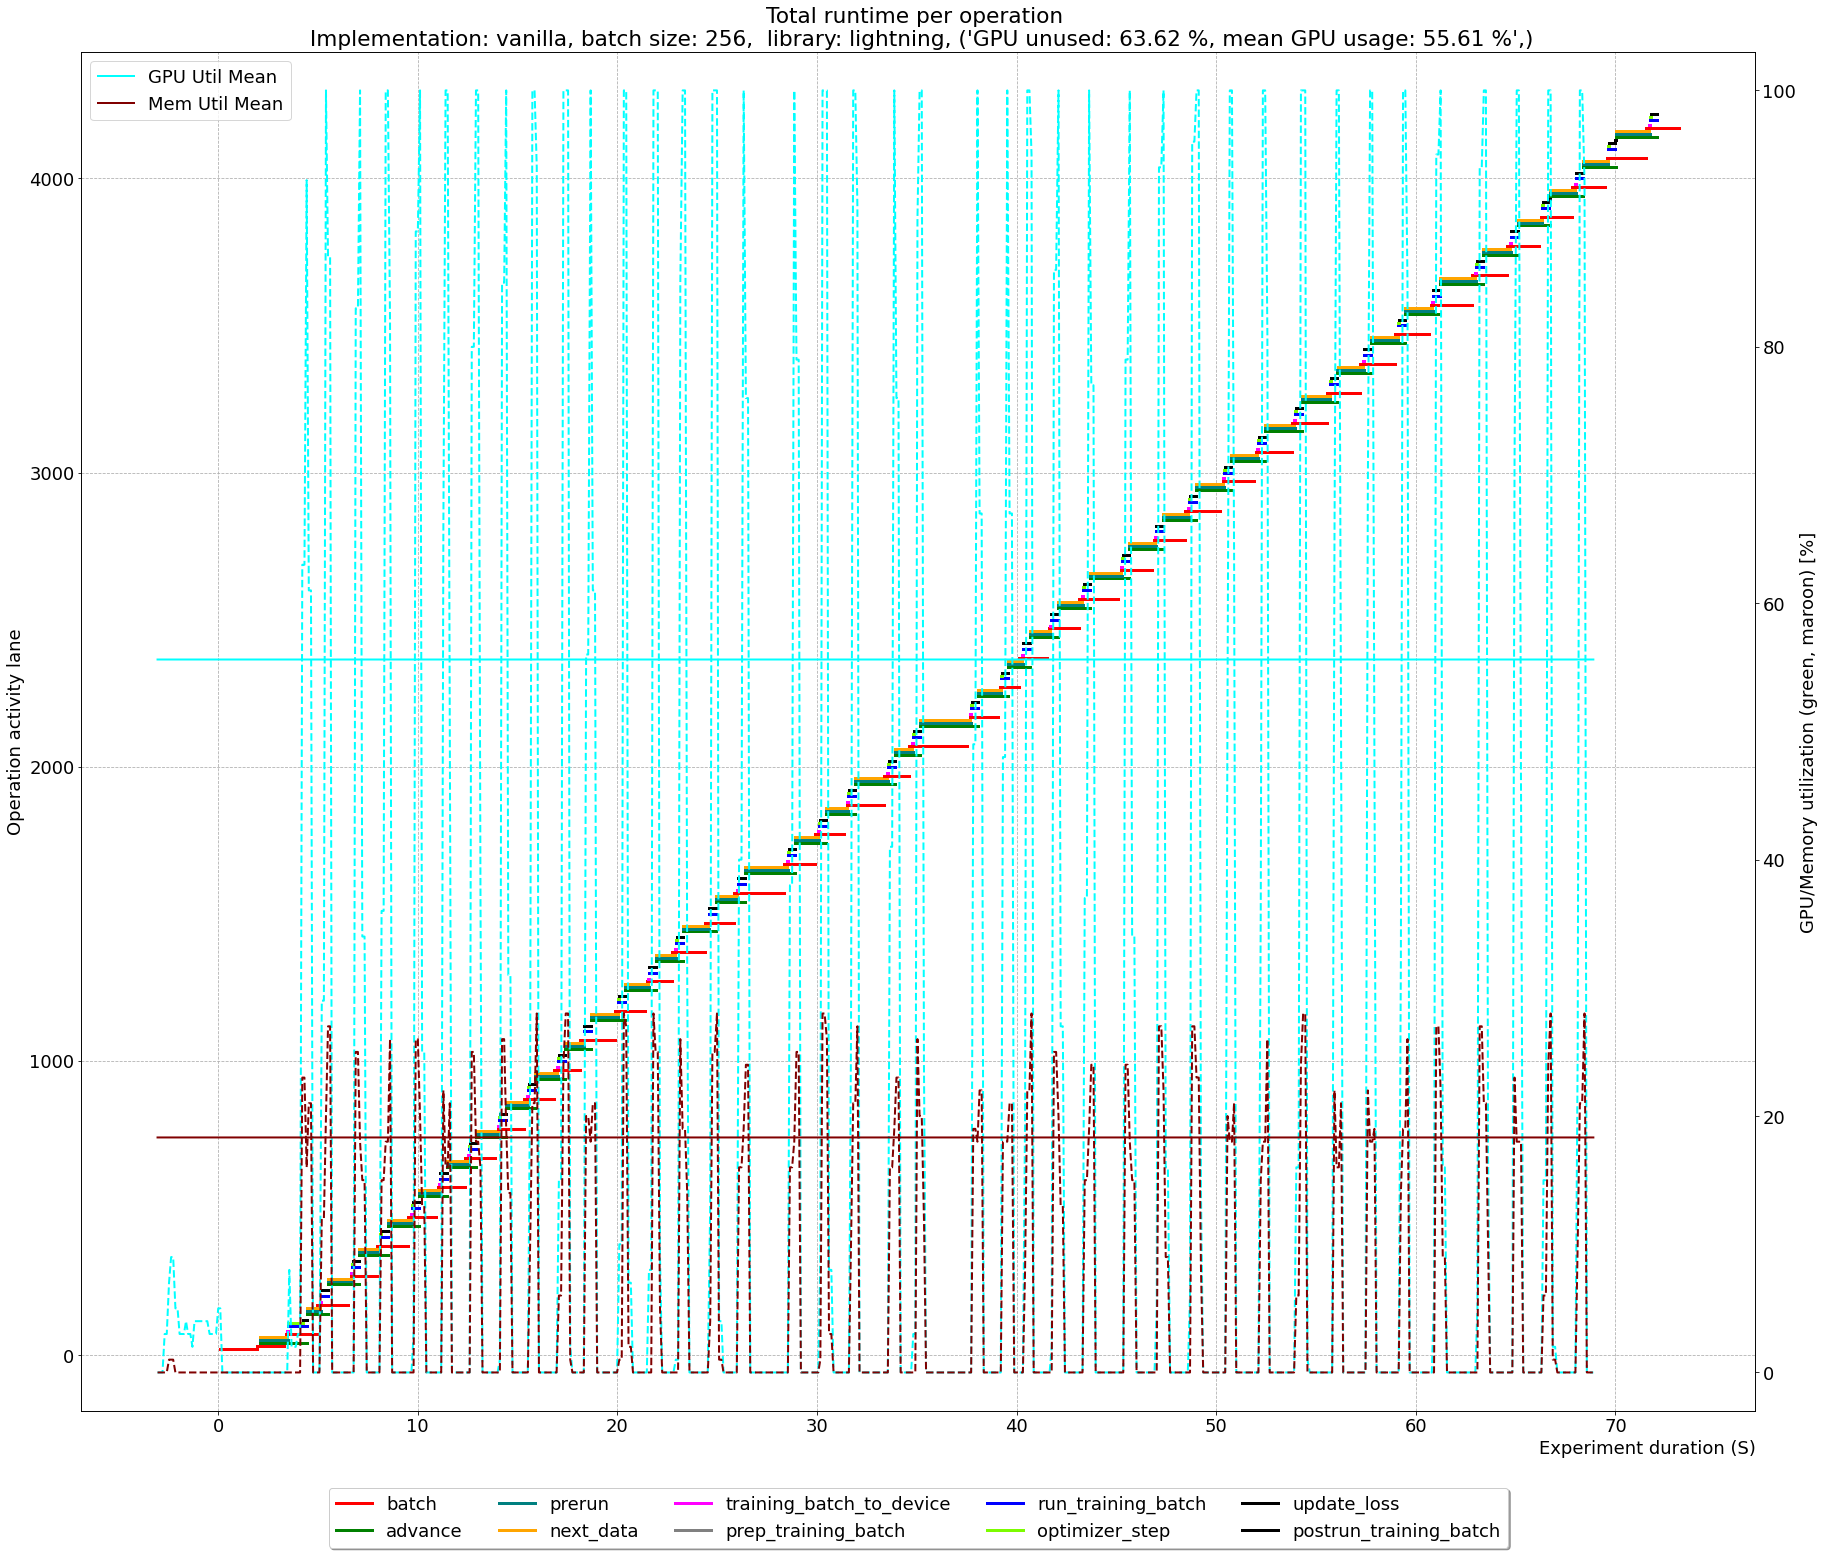

In [43]:
unique_runs_scratch, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_scratch)
print(unique_functions)
returns_scratch = []

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False)
    result = show_timelines_with_gpu2(df=df, gpu_util=dfgpu, lanes=lanes, colors=colors, run=run, 
                                     flat=False, show_gpu=True, zoom=True, zoom_epochs=3,
                                     skip_plot=False, ms=True)
    df = df_dataloader_scratch[(df_dataloader_scratch["item_x"]=="run_training_batch")&(df_dataloader_scratch["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_calc"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_scratch[(df_dataloader_scratch["item_x"]=="training_batch_to_device")&(df_dataloader_scratch["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_transf"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_scratch[(df_dataloader_scratch["item_x"]=="update_loss")&(df_dataloader_scratch["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_update_loss"] = (df["end_time_y"] - df["start_time_x"]).sum()
    df = df_dataloader_scratch[(df_dataloader_scratch["item_x"]=="optimizer_step")&(df_dataloader_scratch["run"]==run)].drop_duplicates(subset=['id'], keep="first", inplace=False) 
    result["duration_optimizer_step"] = (df["end_time_y"] - df["start_time_x"]).sum()
    result["run"]=run
    returns_scratch.append(result)

Get unique runs to loop through, and plot the results

### Result tables
Print throughput in loaded images per second, and function duration in seconds, for S3 and Scratch

In [44]:
# sanity check
get_metadata_info(output_base_folder / "" / unique_runs_s3[0])
5*59

Dataset:  15000
Batch size: 256
Epochs:  5
Images total:  75000
Batches per epoch 59
Images total (rounded):  75520


295

In [45]:
def get_batch_train_time(results, subfolder, df, unique_runs, output_base_folder):
    durations = []
    # functions are logged twice, decorator loggs twice?
    df = df.drop_duplicates(subset=['time_start', 'time_end'], keep="first", inplace=False) 
    for run in sorted(unique_runs):
        # we log bytes! -> b.getbuffer().nbytes or os.path.getsize
        durations.append(df[(df["run"]==run) & (df["trace_name"]=="(7)_batch_advance")]["elapsed"].sum())
#         df_full_scratch[df_full_scratch["trace_name"]=="(7)_batch_advance"]
        print(len(df[(df["run"]==run) & (df["trace_name"]=="(7)_batch_advance")]))

    results["batch_duration"] = durations

    return results

In [72]:
df_full_s3 = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
results_s3 = pd.DataFrame.from_records(data=returns_s3)
r_s3 = get_throughput(results_s3, "", df_full_s3, unique_runs_s3, output_base_folder)
r_s3 = get_batch_train_time(r_s3, "", df_full_s3, unique_runs_s3, output_base_folder)
r_s3["data_part"] = r_s3["runtime"] - r_s3["batch_duration"] 
r_s3["gpu_tp_both"] = (r_s3["dl_MB"] * 8) / (r_s3["duration_transf"] + r_s3["duration_calc"])
r_s3["gpu_tp"] = (r_s3["dl_MB"] * 8) / (r_s3["duration_calc"])
r_s3["gpu_tp_opt"] = (r_s3["dl_MB"] * 8) / (r_s3["duration_optimizer_step"])

r_s3.round(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00, 11.81it/s]


0
0
0
0
0
0


runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0   206.68          42.86                   65.42          19.97   
1   196.11          35.67                   66.99          11.53   
2   224.95          61.16                   75.45          15.55   
3   216.44          29.93                   62.51          11.88   
4  2118.79          95.15                   72.21           1.96   
5  8644.46          97.79                   57.17           0.35   

   mem_util_mean_no_zeros implementation cache    library                fig  \
0                   37.42       threaded     1      torch  Figure(2160x1800)   
1                   21.25       threaded     1  lightning  Figure(2160x1800)   
2                   43.16        asyncio     1      torch  Figure(2160x1800)   
3                   20.93        asyncio     1  lightning  Figure(2160x1800)   
4                   44.58        vanilla     1      torch  Figure(2160x1800)   
5                   19.40        vanilla     1  lightning  Figure(2160x1800)   

   duration_calc  ...  throughput    dl_MB   imgs  Mbit/s   MB/s  \
0          25.00  ...      362.87  8094.53  75000  313.31  39.16   
1         103.64  ...      382.44  8140.49  75000  332.08  41.51   
2          25.09  ...      333.41  8464.63  75000  301.03  37.63   
3         103.54  ...      346.52  8464.63  75000  312.87  39.11   
4          25.95  ...       35.40  8464.63  75000   31.96   4.00   
5         106.55  ...        8.68  8464.63  75000    7.83   0.98   

   batch_duration  data_part  gpu_tp_both   gpu_tp  gpu_tp_opt  
0             0.0     206.68      1080.86  2590.63         inf  
1             0.0     196.11       557.32   628.38     5396.29  
2             0.0     224.95      1245.24  2698.57         inf  
3             0.0     216.44       579.50   654.00     5701.96  
4             0.0    2118.79      1182.31  2609.20         inf  
5             0.0    8644.46       564.44   635.56     5529.37  

[6 rows x 23 columns]

In [48]:
df_full_scratch = extract_pandas(output_base_folder, folder_filter=scratch_folder_filter)
results_scratch = pd.DataFrame.from_records(data=returns_scratch)
r_scratch = get_throughput(results_scratch, "", df_full_scratch, unique_runs_scratch, output_base_folder)
r_scratch["gpu_tp_opt"] = (r_scratch["dl_MB"] * 8) / (r_scratch["duration_optimizer_step"])
r_scratch["gpu_tp"] = (r_scratch["dl_MB"] * 8) / (r_scratch["duration_calc"])

r_scratch.round(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:09<00:00, 11.45it/s]


runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0    89.98           6.33                   83.75          41.97   
1   127.82           4.50                   73.02          18.59   
2    89.64           5.57                   84.50          42.52   
3   127.89           3.91                   71.65          18.43   
4   133.26          28.59                   82.45          31.32   
5   479.74          63.62                   55.61           5.44   

   mem_util_mean_no_zeros implementation cache    library                fig  \
0                   47.53       threaded     1      torch  Figure(2160x1800)   
1                   22.71       threaded     1  lightning  Figure(2160x1800)   
2                   46.93        asyncio     1      torch  Figure(2160x1800)   
3                   22.47        asyncio     1  lightning  Figure(2160x1800)   
4                   45.58        vanilla     1      torch  Figure(2160x1800)   
5                   18.33        vanilla     1  lightning  Figure(2160x1800)   

   duration_calc  duration_transf  duration_update_loss  \
0          24.86            47.62                  0.00   
1         103.62            12.18                 92.04   
2          24.69            47.80                  0.00   
3         103.57            12.22                 91.91   
4          25.33            34.97                  0.00   
5         103.69            12.46                 91.71   

   duration_optimizer_step  throughput    dl_MB   imgs  Mbit/s    MB/s  \
0                     0.00      833.56  9262.42  75000  823.55  102.94   
1                    11.41      586.75  9273.58  75000  580.40   72.55   
2                     0.00      836.68  8456.77  75000  754.73   94.34   
3                    11.48      586.43  8456.77  75000  528.99   66.12   
4                     0.00      562.80  8456.77  75000  507.68   63.46   
5                    11.81      156.34  8456.77  75000  141.02   17.63   

   gpu_tp_opt   gpu_tp  
0         inf  2980.62  
1     6499.76   715.97  
2         inf  2740.44  
3     5891.07   653.23  
4         inf  2671.34  
5     5727.94   652.44

In [ ]:
# LaTeX style
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [50]:
torch_s3 = r_s3[r_s3["library"]=="torch"]
lightning_s3 = r_s3[r_s3["library"]=="lightning"]

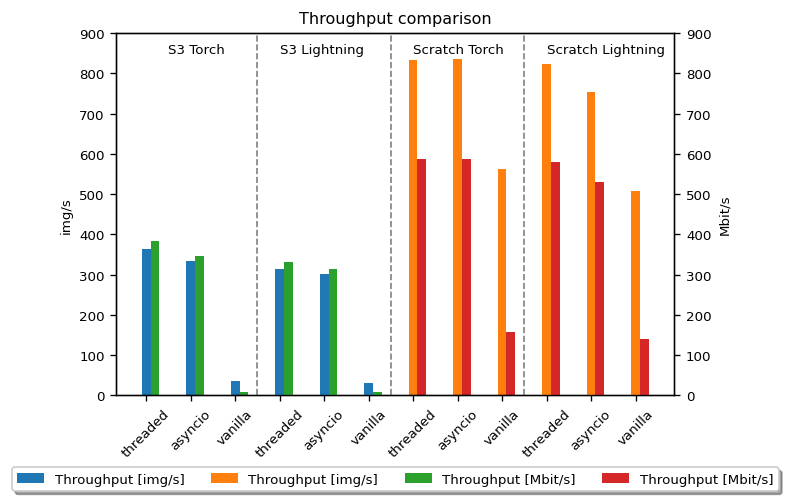

In [51]:
matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(dpi=120)
offset = 0
offset2 = 3

sc_offset = 6
sc_offset2 = 9

width = 0.2
labels = ['threaded', 'asyncio', 'vanilla', 'threaded', 'asyncio', 'vanilla'] * 2


ax2 = ax.twinx()
for lib, lab in zip(["torch", "lightning"], ["Throughput [img/s]", "Throughput [Mbit/s]"]):
    curr = r_s3[r_s3["library"]==lib]["throughput"]
    ax.bar(height=curr, x=np.arange(len(curr))+offset, width=width, label=lab)
    offset += 0.2
    curr = r_s3[r_s3["library"]==lib]["Mbit/s"]
    ax2.bar(height=curr, x=np.arange(len(curr))+offset2, width=width)
    offset2 += 0.2
    
    curr = r_scratch[r_scratch["library"]==lib]["throughput"]
    ax.bar(height=curr, x=np.arange(len(curr))+sc_offset, width=width, label=lab)
    sc_offset += 0.2
    curr = r_scratch[r_scratch["library"]==lib]["Mbit/s"]
    ax2.bar(height=curr, x=np.arange(len(curr))+sc_offset2, width=width)
    sc_offset2 += 0.2
    
ax.text(0.5, 850, "S3 Torch")
ax.text(3.0, 850, "S3 Lightning")
ax.text(6.0, 850, "Scratch Torch")
ax.text(9.0, 850, "Scratch Lightning")


ax.set_ylabel("img/s")
ax2.set_ylabel("Mbit/s")
    
ax.set_ylim([0, 900])
ax2.set_ylim([0, 900])
# ax.grid(linestyle="--", which="both")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=5)

ax.set_xticks(np.arange(len(r_s3)*2), labels, rotation="45")
ax.set_title("Throughput comparison")
plt.axvline(x=2.5, color="gray", linestyle="--", linewidth=1)
plt.axvline(x=5.5, color="gray", linestyle="--", linewidth=1)
plt.axvline(x=8.5, color="gray", linestyle="--", linewidth=1)


In [ ]:
!pip install latex

In [52]:
font_size=30
params = {'legend.fontsize': font_size,
          'figure.figsize': (25, 20),
          'axes.labelsize': font_size,
          'axes.titlesize': font_size,
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size}

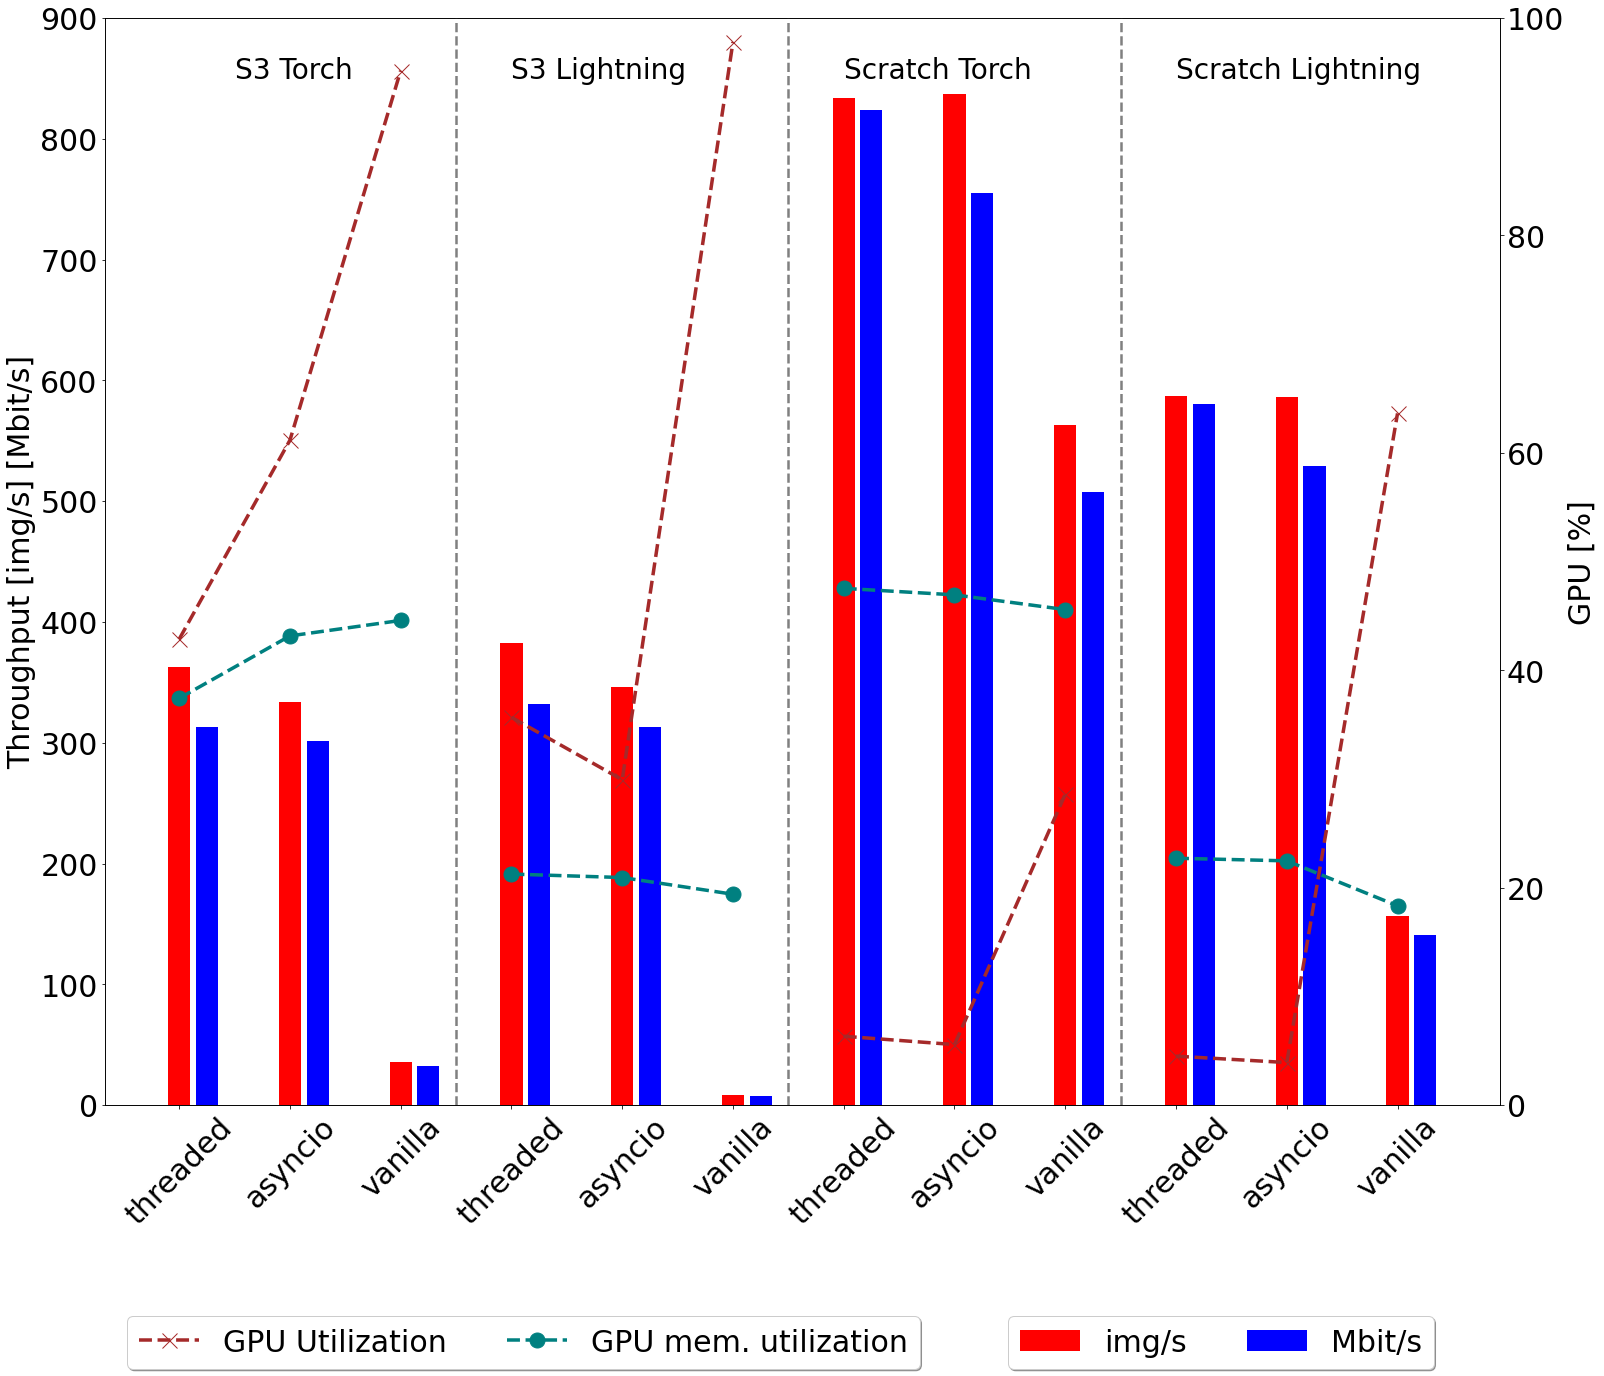

In [53]:

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "Helvetica"
# })
plt.rcParams.update(params)
# matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots()
offset = 0
offset2 = 6
gpu_offset = 0
gpu_offset2 = 0

width = 0.2
labels = ['threaded', 'asyncio', 'vanilla', 'threaded', 'asyncio', 'vanilla'] * 2


ax2 = ax.twinx()
for lib, lab in zip(["torch", "lightning"], ["Throughput [img/s]", "Throughput [Mbit/s]"]):
    # S3
    curr = r_s3[r_s3["library"]==lib]["throughput"]
    ax.bar(height=curr, x=[i + offset for i in range(3)], width=width, label="img/s", color="red")
    curr = r_s3[r_s3["library"]==lib]["Mbit/s"]
    ax.bar(height=curr, x=[i + offset + 0.25 for i in range(3)], width=width, label="Mbit/s", color="blue")
    offset += 3
    # Scratch
    curr = r_scratch[r_scratch["library"]==lib]["throughput"]
    ax.bar(height=curr, x=[i + offset2 for i in range(3)], width=width, label="img/s", color="red")
    curr = r_scratch[r_scratch["library"]==lib]["Mbit/s"]
    ax.bar(height=curr, x=[i + offset2 + 0.25 for i in range(3)], width=width, label="Mbit/s", color="blue")
    offset2 += 3
    # GPU Util
    ax2.plot([i + gpu_offset for i in range(3)], r_s3[r_s3["library"]==lib]["gpu_util_zero"],
             marker = 'x', markersize = 15, color="brown", linestyle="--", linewidth=3.5, label="GPU Utilization")
    ax2.plot([i + gpu_offset for i in range(6, 9)], r_scratch[r_scratch["library"]==lib]["gpu_util_zero"],
         marker = 'x', markersize = 15, color="brown", linestyle="--", linewidth=3.5, label="GPU Utilization")
    gpu_offset += 3
    
    # GPU Unused
    ax2.plot([i + gpu_offset2 for i in range(3)], r_s3[r_s3["library"]==lib]["mem_util_mean_no_zeros"],
             marker = 'o', markersize = 15, color="teal", linestyle="--", linewidth=3.5, label="GPU mem. utilization")
    ax2.plot([i + gpu_offset2 for i in range(6, 9)], r_scratch[r_scratch["library"]==lib]["mem_util_mean_no_zeros"],
         marker = 'o', markersize = 15, color="teal", linestyle="--", linewidth=3.5, label="GPU mem. utilization")
    gpu_offset2 += 3
    
ax.text(0.5, 850, "S3 Torch", fontsize=28)
ax.text(3.0, 850, "S3 Lightning", fontsize=28)
ax.text(6.0, 850, "Scratch Torch", fontsize=28)
ax.text(9.0, 850, "Scratch Lightning", fontsize=28)


ax.set_ylabel("Throughput [img/s] [Mbit/s]")
ax2.set_ylabel("GPU [%]")
    
ax.set_ylim([0, 900])
ax2.set_ylim([0, 100])

ax.legend()
ax2.legend()


ax.set_xticks(np.arange(len(r_s3)*2), labels, rotation="45")
# ax.set_title("Implementation and library comparison, throughput and GPU utilization")
plt.axvline(x=2.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=5.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=8.5, color="gray", linestyle="--", linewidth=2.5)

handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.3, -0.18),
          fancybox=True, shadow=True, ncol=2)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.8, -0.18),
          fancybox=True, shadow=True, ncol=2)

fig.savefig(f"final_measurements.pdf", bbox_inches='tight')

# new

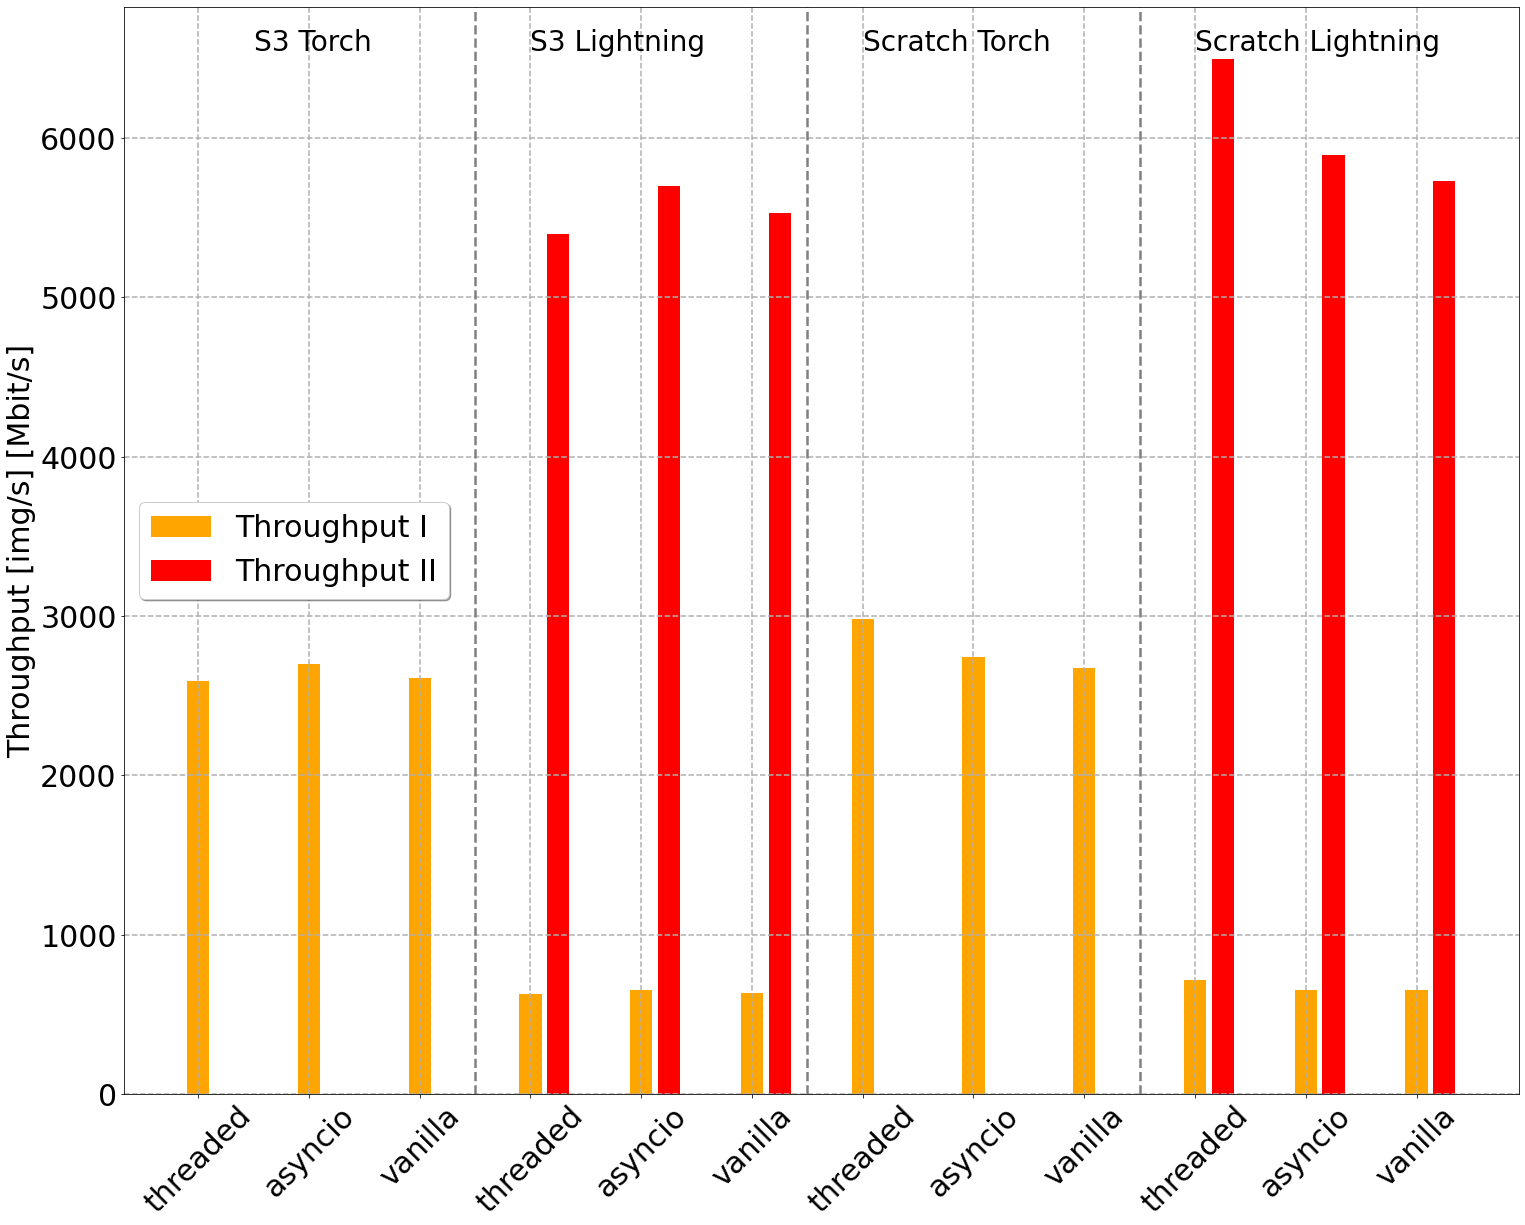

In [128]:

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "Helvetica"
# })
plt.rcParams.update(params)
# matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots()
offset = 0
offset2 = 6
gpu_offset = 0
gpu_offset2 = 0

width = 0.2
labels = ['threaded', 'asyncio', 'vanilla', 'threaded', 'asyncio', 'vanilla'] * 2


# ax2 = ax.twinx()
for lib, lab in zip(["torch", "lightning"], ["Throughput [img/s]", "Throughput [Mbit/s]"]):
    # S3
    key = "gpu_tp" if lib == "lightning" else "gpu_tp_both"
    
    curr = r_s3[r_s3["library"]==lib]["gpu_tp"]
    ax.bar(height=curr, x=[i + offset for i in range(3)], width=width, label="Throughput I", color="orange")
#     offset += 3
    curr = r_s3[r_s3["library"]==lib]["gpu_tp_opt"]
    if curr is not float('inf'):
        ax.bar(height=curr, x=[i + offset + 0.25 for i in range(3)], width=width, label="Throughput II", color="red")
        offset += 3
    
    
    # Scratch
    curr = r_scratch[r_scratch["library"]==lib]["gpu_tp"]
    ax.bar(height=curr, x=[i + offset2 for i in range(3)], width=width, label="Throughput I", color="orange")
#     offset2 += 3
    
    curr = r_scratch[r_scratch["library"]==lib]["gpu_tp_opt"]
    if curr is not float('inf'):
        ax.bar(height=curr, x=[i + offset2 + 0.25 for i in range(3)], width=width, label="Throughput II", color="red")
        offset2 += 3

    
ax.text(0.5, 6550, "S3 Torch", fontsize=28)
ax.text(3.0, 6550, "S3 Lightning", fontsize=28)
ax.text(6.0, 6550, "Scratch Torch", fontsize=28)
ax.text(9.0, 6550, "Scratch Lightning", fontsize=28)


ax.grid(linestyle="--", which="both", linewidth=1.5)
ax.set_ylabel("Throughput [img/s] [Mbit/s]")
# ax.set_ylim([0, 2900])
ax.legend()


ax.set_xticks(np.arange(len(r_s3)*2), labels, rotation="45")
# ax.set_title("Implementation and library comparison, throughput and GPU utilization")
plt.axvline(x=2.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=5.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=8.5, color="gray", linestyle="--", linewidth=2.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left',
          fancybox=True, shadow=True, ncol=1)

fig.savefig(f"gpu_throughput.pdf", bbox_inches='tight')

In [78]:
r_scratch.round(2)

runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0    89.98           6.33                   83.75          41.97   
1   127.82           4.50                   73.02          18.59   
2    89.64           5.57                   84.50          42.52   
3   127.89           3.91                   71.65          18.43   
4   133.26          28.59                   82.45          31.32   
5   479.74          63.62                   55.61           5.44   

   mem_util_mean_no_zeros implementation cache    library                fig  \
0                   47.53       threaded     1      torch  Figure(2160x1800)   
1                   22.71       threaded     1  lightning  Figure(2160x1800)   
2                   46.93        asyncio     1      torch  Figure(2160x1800)   
3                   22.47        asyncio     1  lightning  Figure(2160x1800)   
4                   45.58        vanilla     1      torch  Figure(2160x1800)   
5                   18.33        vanilla     1  lightning  Figure(2160x1800)   

   duration_calc  duration_transf  duration_update_loss  \
0          24.86            47.62                  0.00   
1         103.62            12.18                 92.04   
2          24.69            47.80                  0.00   
3         103.57            12.22                 91.91   
4          25.33            34.97                  0.00   
5         103.69            12.46                 91.71   

   duration_optimizer_step  throughput    dl_MB   imgs  Mbit/s    MB/s  \
0                     0.00      833.56  9262.42  75000  823.55  102.94   
1                    11.41      586.75  9273.58  75000  580.40   72.55   
2                     0.00      836.68  8456.77  75000  754.73   94.34   
3                    11.48      586.43  8456.77  75000  528.99   66.12   
4                     0.00      562.80  8456.77  75000  507.68   63.46   
5                    11.81      156.34  8456.77  75000  141.02   17.63   

   gpu_tp_opt   gpu_tp  
0         inf  2980.62  
1     6499.76   715.97  
2         inf  2740.44  
3     5891.07   653.23  
4         inf  2671.34  
5     5727.94   652.44

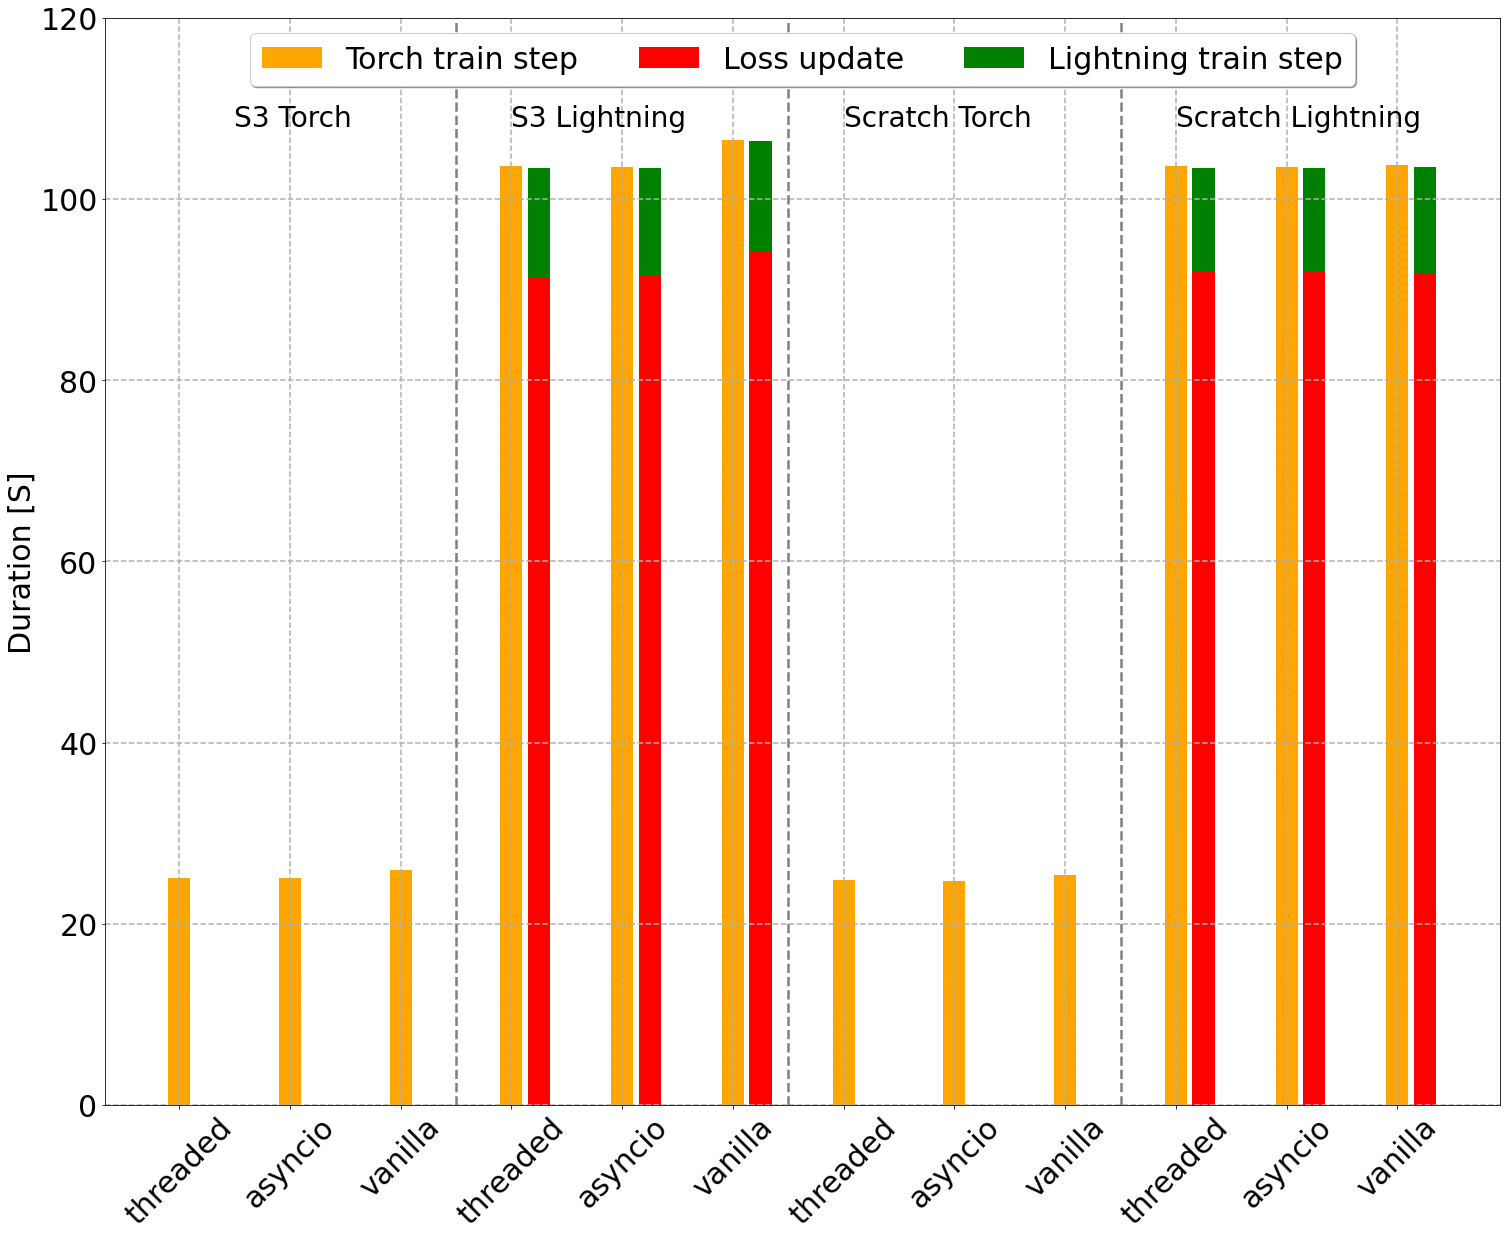

In [129]:

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "Helvetica"
# })
plt.rcParams.update(params)
# matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots()
offset_s3 = 0
offset_scratch = 6
gpu_offset = 0
gpu_offset2 = 0

width = 0.2
labels = ['threaded', 'asyncio', 'vanilla', 'threaded', 'asyncio', 'vanilla'] * 2


# ax2 = ax.twinx()
for lib, lab in zip(["torch", "lightning"], ["Throughput [img/s]", "Throughput [Mbit/s]"]):
    # S3    
    duration_calc = r_s3[r_s3["library"]==lib]["duration_calc"]
    duration_calc_x = [i + offset_s3 for i in range(3)]
    ax.bar(height=duration_calc, x=duration_calc_x, width=width, label="Torch train step", color="orange")
    
    duration_update_loss = r_s3[r_s3["library"]==lib]["duration_update_loss"]
    duration_optimizer_step = r_s3[r_s3["library"]==lib]["duration_optimizer_step"]
    duration_update_loss_x = [i + offset_s3 + 0.25 for i in range(3)]
    duration_optimizer_step_x = [i + offset_s3 + 0.25 for i in range(3)]
    
    if curr is not float('inf'):
        ax.bar(height=duration_update_loss, x=duration_update_loss_x, 
               width=width, label="Loss update", 
               color="red")
        ax.bar(height=duration_optimizer_step, x=duration_optimizer_step_x, 
               width=width, label="Lightning train step", 
               bottom=duration_update_loss,
               color="green")
        offset_s3 += 3

    
    
    # Scratch
    duration_calc = r_scratch[r_scratch["library"]==lib]["duration_calc"]
    duration_calc_x = [i + offset_scratch for i in range(3)]
    ax.bar(height=duration_calc, x=duration_calc_x, width=width, label="Train step", color="orange")
    
    duration_update_loss = r_scratch[r_scratch["library"]==lib]["duration_update_loss"]
    duration_optimizer_step = r_scratch[r_scratch["library"]==lib]["duration_optimizer_step"]
    duration_update_loss_x = [i + offset_scratch + 0.25 for i in range(3)]
    duration_optimizer_step_x = [i + offset_scratch + 0.25 for i in range(3)]
    
    if curr is not float('inf'):
        ax.bar(height=duration_update_loss, x=duration_update_loss_x, 
               width=width, label="Loss update", 
               color="red")
        ax.bar(height=duration_optimizer_step, x=duration_optimizer_step_x, 
               width=width, label="Lightning train step (only)", 
               bottom=duration_update_loss,
               color="green")
        offset_scratch += 3

    
ax.text(0.5, 108, "S3 Torch", fontsize=28)
ax.text(3.0, 108, "S3 Lightning", fontsize=28)
ax.text(6.0, 108, "Scratch Torch", fontsize=28)
ax.text(9.0, 108, "Scratch Lightning", fontsize=28)


ax.grid(linestyle="--", which="both", linewidth=1.5)
ax.set_ylabel("Duration [S]")
ax.set_ylim([0, 120])
ax.legend()


ax.set_xticks(np.arange(len(r_s3)*2), labels, rotation="45")
# ax.set_title("Implementation and library comparison, throughput and GPU utilization")
plt.axvline(x=2.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=5.5, color="gray", linestyle="--", linewidth=2.5)
plt.axvline(x=8.5, color="gray", linestyle="--", linewidth=2.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center',
          fancybox=True, shadow=True, ncol=3)

fig.savefig(f"gpu_calc_time.pdf", bbox_inches='tight')